In [312]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_rel, wilcoxon
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import numpy as np
from sklearn.linear_model import Lasso, Ridge
from scipy.stats import loguniform
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.metrics import r2_score
import math
#Le R² varie de 0 à 1, où une valeur de 1 indique que le modèle ajuste parfaitement les données et explique 100% de la variance de la variable dépendante, 
# #tandis qu'une valeur de 0 indique que le modèle ne parvient pas à expliquer la variance de la variable dépendante et que les prédictions sont équivalentes à 
# la moyenne des données.
#En général, un R² plus élevé indique que le modèle ajuste mieux les données et explique une plus grande proportion de la variance de la variable dépendante. 
# Cependant, il est important de noter que le R² ne doit pas être utilisé comme seul critère pour évaluer la qualité d'un modèle, 


from sklearn.metrics import mean_absolute_error

from sklearn.feature_selection import RFE
#on entraine les hyper parametree avant ou apres avoir selectionné les variables

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [313]:
wines_ = pd.read_excel("data/Subset1.xls", 1)
print(min(wines_['DOY']))

213.0


On ne peut donc au maximum prendre comme data que les 213 jours précédent la récolte, une information supplémentaire n'est probablement pas importante car on va surtout analyser l'effet de la météo d'une année sur le vin

In [314]:
wines_.dropna(subset = ['Harvest date'], inplace=True)
wines_.reset_index(drop=True, inplace=True)


In [315]:
weather = pd.read_excel("data/Subset3.xls", [1,2,3,4,5])

In [316]:
#creation de 3 dataframes vides pour contenir les temperatures min max et avg
i = list(range(1,201))
i = list(map(str, i))
iavg = ['avg' + item for item in i]
imin = ['min' + item for item in i]
imax = ['max' + item for item in i]
temp_avg = pd.DataFrame(columns = iavg)
temp_min = pd.DataFrame(columns = imin)
temp_max = pd.DataFrame(columns = imax)

In [317]:
wines = wines_.copy()

In [318]:
# creation du dataframe temp_avg qui contient tous les vins, avec 200 colonnes contenant la temperature moyenne (de la region) des 200 jours avant la recolte
for i in range(len(wines)):
    new_row = []
    r = wines["Reg"][i]
    d = wines['Harvest date'][i]
    h = int(wines['DOY'][i])
    new_row = list(weather[r].loc[(weather[r]['Year'] == d.year) & (weather[r]['DOY'].isin(range(h-200,h)))]['Tave'])
    if len(new_row) != 200:
        new_row = [float('nan')] * 200
    temp_avg.loc[len(temp_avg)] = new_row

In [319]:
#temp_min contient tous les vins, avec 200 colonnes contenant la temperature min (de la region) des 200 jours avant la recolte
for i in range(len(wines)):
    new_row = []
    r = wines["Reg"][i]
    d = wines['Harvest date'][i]
    h = int(wines['DOY'][i])
    new_row = list(weather[r].loc[(weather[r]['Year'] == d.year) & (weather[r]['DOY'].isin(range(h-200,h)))]['Tmin'])
    if len(new_row) != 200:
        new_row = [float('nan')] * 200
    temp_min.loc[len(temp_min)] = new_row

In [320]:
#temp_max contient tous les vins, avec 200 colonnes contenant la temperature min (de la region) des 200 jours avant la recolte 
for i in range(len(wines)):
    new_row = []
    r = wines["Reg"][i]
    d = wines['Harvest date'][i]
    h = int(wines['DOY'][i])
    new_row = list(weather[r].loc[(weather[r]['Year'] == d.year) & (weather[r]['DOY'].isin(range(h-200,h)))]['Tmax'])
    if len(new_row) != 200:
        new_row = [float('nan')] * 200
    temp_max.loc[len(temp_max)] = new_row

In [321]:
print(temp_avg.isnull().sum(axis = 0)) 
print(temp_min.isnull().sum(axis = 0))
print(temp_max.isnull().sum(axis = 0))

avg1      102
avg2      102
avg3      102
avg4      102
avg5      102
         ... 
avg196    102
avg197    102
avg198    102
avg199    102
avg200    102
Length: 200, dtype: int64
min1      102
min2      102
min3      102
min4      102
min5      102
         ... 
min196    102
min197    102
min198    102
min199    102
min200    102
Length: 200, dtype: int64
max1      102
max2      102
max3      102
max4      102
max5      102
         ... 
max196    102
max197    102
max198    102
max199    102
max200    102
Length: 200, dtype: int64


we have the same missing values for Tmin, Tmax and Taverage

In [322]:
#on concatene temp_min et temp_max sans temp_avg car c'est une information redondante
all_temp = pd.concat([temp_min,temp_max], axis = 1)

# Now to aggregate the temperatures

### choose the time spans with ```nb_jour```

In [323]:
nb_jour = 10

In [324]:
#reduction de dimension, ca enleve la variabilité des données qui correspondent au bruit donc ca permet de savoir ce qu'est vraiment nos données
#elimination de variable, on entraine un modele sur nos donneés, on trouve la variable (l'attribut) qui contirbue le moins et on la supprimes

#fonction qui prend en argument le chiffre par lequel on va partioonner notre dataset : exemple 10 alors il y aura 10 colonnes 
#de temperature qui vont prendre la moyenne des 20 jours
def colonne_nb_jour_avg(nb_jour):
    temperatures_bis = pd.DataFrame()
    addition = temp_avg.shape[1]//nb_jour
    if temp_avg.shape[1]%nb_jour !=0:
        print("trouver une autre valeur")
    else:
        for index in range(nb_jour): 
            colonnes = []
            for i in range(index*addition+1, index*addition+ addition +1):
                colonnes.append(f"avg{i}")  
            moyenne = temp_avg[colonnes].mean(axis=1)
            temperatures_bis[f"s{nb_jour}avg{index + 1}"] = moyenne
    return temperatures_bis

In [325]:
def colonne_nb_jour_min(nb_jour):
    temperatures_bis = pd.DataFrame()
    addition = temp_min.shape[1]//nb_jour
    if temp_min.shape[1]%nb_jour !=0:
        print("trouver une autre valeur")
    else:
        for index in range(nb_jour): 
            colonnes = []
            for i in range(index*addition+1, index*addition+ addition +1):
                colonnes.append(f"min{i}")  
            min = temp_min[colonnes].mean(axis=1)
            temperatures_bis[f"s{nb_jour}min{index + 1}"] = min
    return temperatures_bis

In [326]:
def colonne_nb_jour_max(nb_jour):
    temperatures_bis = pd.DataFrame()
    addition = temp_max.shape[1]//nb_jour
    if temp_max.shape[1]%nb_jour !=0:
        print("trouver une autre valeur")
    else:
        for index in range(nb_jour): 
            colonnes = []
            for i in range(index*addition+1, index*addition+ addition +1):
                colonnes.append(f"max{i}")  
            max = temp_max[colonnes].mean(axis=1)
            temperatures_bis[f"s{nb_jour}max{index + 1}"] = max
    return temperatures_bis

In [327]:
agg_temp_min = colonne_nb_jour_min(nb_jour)
agg_temp_max =colonne_nb_jour_max(nb_jour)
agg_temp_avg=colonne_nb_jour_avg(nb_jour)

agg_all_temp = pd.concat([agg_temp_min,agg_temp_max], axis = 1)

In [328]:
def count_values_in_interval(row, interval_start, interval_end):
    count = 0
    for val in row:
        if interval_start <= val < interval_end:
            count += 1
    return count

In [329]:
#choice = 2 pour utiliser avg, 1 pour min 3 pour max
def intervalle(choice):
    if choice == 1:
        temp= temp_min
    if choice == 2:
        temp= temp_avg
    if choice == 3:
        temp= temp_max
    df = pd.DataFrame()
    df[f"{choice}intervalle_-5"] = temp.apply(lambda row: count_values_in_interval(row, -50, -5), axis=1)
    df[f"{choice}intervalle_-5-0"] = temp.apply(lambda row: count_values_in_interval(row, -5, 0), axis=1)
    df[f"{choice}intervalle_0-5"] = temp.apply(lambda row: count_values_in_interval(row, 0, 5), axis=1)
    df[f"{choice}intervalle_5-10"] = temp.apply(lambda row: count_values_in_interval(row, 5, 10), axis=1)
    df[f"{choice}intervalle_10-15"] = temp.apply(lambda row: count_values_in_interval(row, 10, 15), axis=1)
    df[f"{choice}intervalle_15-20"] = temp.apply(lambda row: count_values_in_interval(row, 15, 20), axis=1)
    df[f"{choice}intervalle_20-25"] = temp.apply(lambda row: count_values_in_interval(row, 20, 25), axis=1)
    df[f"{choice}intervalle_25-30"] = temp.apply(lambda row: count_values_in_interval(row, 25, 30), axis=1)
    df[f"{choice}intervalle_30-35"] = temp.apply(lambda row: count_values_in_interval(row, 30, 35), axis=1)
    df[f"{choice}intervalle_35-40"] = temp.apply(lambda row: count_values_in_interval(row, 35, 40), axis=1)
    df[f"{choice}intervalle_40-"] = temp.apply(lambda row: count_values_in_interval(row, 40, 100), axis=1)
    return df

In [330]:
int_temp_min = intervalle(1)
int_temp_max =intervalle(3)
int_temp_avg=intervalle(2)

int_all_temp= pd.concat([int_temp_min,int_temp_max], axis = 1)

In [331]:
def count_above_thresh(row, t):
    return (row > t).sum()

def days_over(choice = 'max'):
    if choice == 'min':
        temp= temp_min
    if choice == 'avg':
        temp= temp_avg
    if choice == 'max':
        temp= temp_max
    columns = list(range(int(temp.min().min())+1,int(temp.max().max())))
    df = pd.DataFrame()
    for num in columns:
        col_name = f"Over_{num}{choice}"
        df[col_name] = temp.apply(lambda row: (row >= num).sum(), axis=1)
    return df

In [332]:
temp_max_over = days_over(choice = 'max')
temp_min_over = days_over(choice = 'min')
both_over = pd.concat([temp_max_over,temp_min_over], axis = 1)

# Choose the temperature chosen

* ```temp_min``` - the minimal temperatures for each day
* ```temp_avg``` - the average temperatures for each day
* ```temp_max``` - the maximal temperatures for each day
* ```all_temp``` - the concatenation of temp_min and temp_max
* ```agg_temp_min``` - the min temperatures averaged over periods of ```nb_jour```
* ```agg_temp_avg``` - the avg temperatures averaged over periods of ```nb_jour```
* ```agg_temp_max``` - the max temperatures averaged over periods of ```nb_jour```
* ```agg_all_temp``` - the concatenation of agg_temp_min and agg_temp_max
* ```int_temp_min``` - number of days where temp min in intervals
* ```int_temp_max``` - number of days where temp max in intervals
* ```int_temp_avg``` - number of days where temp avg in intervals
* ```int_all_temp``` - the concatenation of int_temp_min and int_temp_max
* ```temp_max_over``` - days over threshold temperatures for tmax
* ```temp_min_over``` _ days over threshold temperatures for tmin
* ```both_over``` - the two above


In [333]:
temperatures = int_all_temp.copy()
temperatures

,1intervalle_-5,1intervalle_-5-0,1intervalle_0-5,1intervalle_5-10,1intervalle_10-15,1intervalle_15-20,1intervalle_20-25,1intervalle_25-30,1intervalle_30-35,1intervalle_35-40,...,3intervalle_-5-0,3intervalle_0-5,3intervalle_5-10,3intervalle_10-15,3intervalle_15-20,3intervalle_20-25,3intervalle_25-30,3intervalle_30-35,3intervalle_35-40,3intervalle_40-
0,0,2,17,75,91,15,0,0,0,0,...,0,0,0,8,17,73,25,42,30,5
1,0,4,24,80,77,13,2,0,0,0,...,0,0,0,8,27,47,34,28,44,12
2,0,0,35,93,70,2,0,0,0,0,...,0,0,0,3,25,54,64,40,14,0
3,0,0,33,71,86,9,1,0,0,0,...,0,0,0,13,32,39,41,52,15,8
4,0,4,50,82,57,7,0,0,0,0,...,0,0,0,6,34,66,49,38,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1468,0,0,14,74,97,15,0,0,0,0,...,0,0,0,0,5,34,49,57,46,9
1469,0,0,2,58,127,12,1,0,0,0,...,0,0,0,2,16,21,53,65,40,3
1470,0,2,10,98,74,12,4,0,0,0,...,0,0,0,0,8,30,47,64,42,9
1471,0,0,18,76,91,15,0,0,0,0,...,0,0,0,1,11,36,43,54,46,9


# On encode la colonne couleur pour l'utiliser dans notre apprentissage
On a seulement deux catégories donc la notion d'équidistence entre chaque catégorie n'est pas forcément importante, on peut se contenter d'encoder par 0 1 ou -1 1 et par la même occasion ne pas augmenter non nécessairement la dimension.

In [334]:
mapping = {'White': -1, 'Red': 1}

wines['Color'] = wines['Color'].map(mapping).fillna(wines['Color'])
wines

,Table.No.,Cultivar,Color,Recommend,RecReg,Reg,Harvest date,DOY,Must.Brix,Must.Tacid,Must.pH,Wine.Alcohol,Wine.Facid,Wine.Extract,Wine.Tannin,Wine.Tasting
0,9,Chardony,-1,Particularly recommended,1.0,3,1936-09-08,251.0,27.2,0.54,3.88,15.6,0.42,4.0,0.03,"Very distinct; good, but alcoholic"
1,9,Chardony,-1,Particularly recommended,1.0,4,1936-08-31,243.0,23.5,0.67,3.79,13.0,0.39,NaN,NaN,Distinct; lacks acid; standard quality
2,9,Chardony,-1,Particularly recommended,1.0,1,1937-10-01,273.0,22.1,0.72,3.38,12.0,0.52,2.0,0.03,Light body; fruity; distinct; good quality
3,9,Chardony,-1,Particularly recommended,1.0,3,1937-09-11,253.0,24.6,0.63,3.69,12.8,0.49,2.1,0.03,Flat; tends to oxidize; but distinct
4,9,Chardony,-1,Particularly recommended,1.0,1,1938-09-14,256.0,19.8,0.78,3.19,10.5,0.68,2.8,0.07,"Tart, but palatable; distinct; picked too early"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1468,25,Red Malaga (Molinera),1,Table grape,NaN,4,1937-10-25,297.0,21.8,0.47,3.74,12.0,0.28,2.3,0.04,Very flat; some spoilage; very ordiry sherry
1469,25,Red Malaga (Molinera),1,Table grape,NaN,4,1940-10-07,280.0,22.7,0.36,3.90,12.4,0.40,2.8,0.04,Flat; pink; very common; lacks everything
1470,25,Ribier,1,Table grape,NaN,4,1935-11-01,304.0,20.2,0.55,NaN,10.8,0.34,2.5,0.08,"Flat; poor; sherry; soft, but no character"
1471,25,Ribier,1,Table grape,NaN,4,1937-10-13,285.0,17.6,0.50,3.58,9.5,0.35,2.1,0.06,Flat; ordiry; tends to spoil


In [335]:
#fonction pour one-hot encode le cepage
one_hot_data = pd.get_dummies(wines['Cultivar'])

dataset2 = pd.concat([wines, one_hot_data], axis=1)

#supprime la colonne 'Culivar'
dataset2.drop('Cultivar', axis=1, inplace=True)

dataset2

,Table.No.,Color,Recommend,RecReg,Reg,Harvest date,DOY,Must.Brix,Must.Tacid,Must.pH,...,Trousseau,Valdepes,Verccia Sarda,Verccia bianca,Verdelho,Vermentino Favorita,Walschriesling,White Riesling,Zinfandel,sa Veltliner
0,9,-1,Particularly recommended,1.0,3,1936-09-08,251.0,27.2,0.54,3.88,...,False,False,False,False,False,False,False,False,False,False
1,9,-1,Particularly recommended,1.0,4,1936-08-31,243.0,23.5,0.67,3.79,...,False,False,False,False,False,False,False,False,False,False
2,9,-1,Particularly recommended,1.0,1,1937-10-01,273.0,22.1,0.72,3.38,...,False,False,False,False,False,False,False,False,False,False
3,9,-1,Particularly recommended,1.0,3,1937-09-11,253.0,24.6,0.63,3.69,...,False,False,False,False,False,False,False,False,False,False
4,9,-1,Particularly recommended,1.0,1,1938-09-14,256.0,19.8,0.78,3.19,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1468,25,1,Table grape,NaN,4,1937-10-25,297.0,21.8,0.47,3.74,...,False,False,False,False,False,False,False,False,False,False
1469,25,1,Table grape,NaN,4,1940-10-07,280.0,22.7,0.36,3.90,...,False,False,False,False,False,False,False,False,False,False
1470,25,1,Table grape,NaN,4,1935-11-01,304.0,20.2,0.55,NaN,...,False,False,False,False,False,False,False,False,False,False
1471,25,1,Table grape,NaN,4,1937-10-13,285.0,17.6,0.50,3.58,...,False,False,False,False,False,False,False,False,False,False


### dataset2 ne sera probablement pas utile. En effet on augmente beaucoup trop la dimension par rapport à la quantité de données.
probleme : il y a beaucoup de différentes catégories donc beaucoup de dimension sont ajoutés. On a déjà beaucoup de dimension comparé aux nombres d'observations donc cela augmentera seulement le probleme
On peut essayer avec le feature encoding a la place


In [336]:
from sklearn.feature_extraction import FeatureHasher

n_features = 20
hasher = FeatureHasher(n_features=n_features, input_type='string')
cultivar_list = [[x] for x in wines['Cultivar'].tolist()]
# Perform feature hashing on the 'fruits' column
hashed_features = hasher.fit_transform(cultivar_list)

hashed_features_names = ['f'+str(i) for i in range(n_features)]
hashed_features_df = pd.DataFrame(hashed_features.toarray(), columns=hashed_features_names)
display(hashed_features_df)
dataset4 = pd.concat([wines, hashed_features_df], axis=1)
dataset4.drop('Cultivar', axis=1, inplace=True)

#wines = dataset4


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17,f18,f19
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1468,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0
1469,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0
1470,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1471,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [337]:
dataset = pd.concat([wines,temperatures], axis = 1)
dataset

,Table.No.,Cultivar,Color,Recommend,RecReg,Reg,Harvest date,DOY,Must.Brix,Must.Tacid,...,3intervalle_-5-0,3intervalle_0-5,3intervalle_5-10,3intervalle_10-15,3intervalle_15-20,3intervalle_20-25,3intervalle_25-30,3intervalle_30-35,3intervalle_35-40,3intervalle_40-
0,9,Chardony,-1,Particularly recommended,1.0,3,1936-09-08,251.0,27.2,0.54,...,0,0,0,8,17,73,25,42,30,5
1,9,Chardony,-1,Particularly recommended,1.0,4,1936-08-31,243.0,23.5,0.67,...,0,0,0,8,27,47,34,28,44,12
2,9,Chardony,-1,Particularly recommended,1.0,1,1937-10-01,273.0,22.1,0.72,...,0,0,0,3,25,54,64,40,14,0
3,9,Chardony,-1,Particularly recommended,1.0,3,1937-09-11,253.0,24.6,0.63,...,0,0,0,13,32,39,41,52,15,8
4,9,Chardony,-1,Particularly recommended,1.0,1,1938-09-14,256.0,19.8,0.78,...,0,0,0,6,34,66,49,38,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1468,25,Red Malaga (Molinera),1,Table grape,NaN,4,1937-10-25,297.0,21.8,0.47,...,0,0,0,0,5,34,49,57,46,9
1469,25,Red Malaga (Molinera),1,Table grape,NaN,4,1940-10-07,280.0,22.7,0.36,...,0,0,0,2,16,21,53,65,40,3
1470,25,Ribier,1,Table grape,NaN,4,1935-11-01,304.0,20.2,0.55,...,0,0,0,0,8,30,47,64,42,9
1471,25,Ribier,1,Table grape,NaN,4,1937-10-13,285.0,17.6,0.50,...,0,0,0,1,11,36,43,54,46,9


On peut utiliser cela si on veut faire que les vins blanc d'un côté ou rouge

In [338]:
# Choose the the color white, red or both in your dataset
# color = -1
# dataset = dataset.loc[dataset['Color'] == color]

In [339]:
print(dataset.isna().sum()) #on peut supprimer je pense

Table.No.               0
Cultivar                0
Color                   0
Recommend               0
RecReg               1025
Reg                     0
Harvest date            0
DOY                     0
Must.Brix               2
Must.Tacid             12
Must.pH               230
Wine.Alcohol           15
Wine.Facid             18
Wine.Extract           23
Wine.Tannin            33
Wine.Tasting            2
1intervalle_-5          0
1intervalle_-5-0        0
1intervalle_0-5         0
1intervalle_5-10        0
1intervalle_10-15       0
1intervalle_15-20       0
1intervalle_20-25       0
1intervalle_25-30       0
1intervalle_30-35       0
1intervalle_35-40       0
1intervalle_40-         0
3intervalle_-5          0
3intervalle_-5-0        0
3intervalle_0-5         0
3intervalle_5-10        0
3intervalle_10-15       0
3intervalle_15-20       0
3intervalle_20-25       0
3intervalle_25-30       0
3intervalle_30-35       0
3intervalle_35-40       0
3intervalle_40-         0
dtype: int64

# Mise en place d'une analyse avec tout d'abord la color du wine comme attribute et le ph à prédire

In [340]:
tested = 'Must.pH'
to_drop = ['Table.No.', 'Recommend', 'RecReg', 'Reg', 'Must.pH','Wine.Alcohol', 'Cultivar',
       'Harvest date', 'DOY', 'Must.Brix', 'Must.Tacid', 'Wine.Facid', 'Wine.Extract', 'Wine.Tannin',
       'Wine.Tasting']
to_drop.remove(tested)

In [341]:
copie = dataset.copy()

#enlever les colonnes qu'on ne compte pas utiliser
copie = copie.drop(columns = to_drop)


In [342]:
columns = list(temperatures.columns)
columns.append('Color')
columns.append(tested)

#supprime row with value = Nan
copie.dropna(subset = columns, inplace=True)
copie.reset_index(drop=True, inplace=True)

In [343]:
# classe à prédire
y = copie[[tested]]

colonnes = list(temperatures.columns)
colonnes.append('Color')

X = copie[colonnes]

In [344]:
def plot_true_vs_predicted(y_true, y_pred):
    """
    Trace un graphique de dispersion des vraies valeurs (y_true) par rapport aux valeurs prédites (y_pred).
    y_true : array de shape (n_samples,)
        Les vraies valeurs de la variable cible.
    y_pred : array de shape (n_samples,)
        Les valeurs prédites de la variable cible.
    """
    min_value = min(min(y_true), min(y_pred))
    max_value = max(max(y_true), max(y_pred))
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.scatter(y_true, y_pred, s=30, alpha=0.5)
    ax.set_xlabel("Valeurs réelles")
    ax.set_ylabel("Valeurs prédites")
    ax.set_xlim([min_value, max_value])
    ax.set_ylim([min_value, max_value])
    ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
    ax.set_title("Valeurs réelles vs. Valeurs prédites")
    plt.show()

In [345]:
def plot_residuals(y_true, y_pred):
    """
    Trace un histogramme des résidus.
    y_true : array de shape (n_samples,)
        Les vraies valeurs de la variable cible.
    y_pred : array de shape (n_samples,)
        Les valeurs prédites de la variable cible.
    """
    residuals = y_true - y_pred
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.hist(residuals, bins=30)
    ax.set_xlabel('Résidus')
    ax.set_ylabel('Fréquence')
    ax.set_title('Histogramme des résidus')
    ax.axvline(np.mean(residuals), color='red', linestyle='dashed', linewidth=1)
    plt.show()

In [346]:
def plot_scores(k):
    m=exp_models[k]
    mean_test_scores = m.cv_results_['mean_test_mse']
    mean_test_r2_scores = m.cv_results_['mean_test_r2']
    std_test_score = m.cv_results_['std_test_mse']
    std_test_r2_scores = m.cv_results_['std_test_r2']
    best_i = m.best_index_

    plt.figure(figsize=(8, 6))
    plt.errorbar(mean_test_scores, mean_test_r2_scores, xerr = std_test_score ,yerr=std_test_r2_scores, fmt='o', capsize=5)
    plt.scatter(mean_test_scores[best_i], mean_test_r2_scores[best_i], color='red', s=50, zorder=10)
    plt.xlabel('MSE')
    plt.ylabel('R2 Score')
    plt.title(f'{k} Test R2 vs. neg MSE')
    plt.show()

In [347]:
def plot_hists(y_true, y_pred):
    min_value = min(min(y_true), min(y_pred))
    max_value = max(max(y_true), max(y_pred))

    plt.hist(y_pred, bins=30, range=(min_value, max_value), color='blue', alpha=0.5, label='Predicted')
    plt.hist(y_true, bins=30, range=(min_value, max_value), color='green', alpha=0.5, label='True')

    plt.title('Histograms of Predicted and True Values')
    plt.xlabel('Values')
    plt.ylabel('Frequency')

    plt.legend(loc='upper right')

    plt.show()

In [348]:
def trend_param(k, p):
    model = exp_models[k]
    results = model.cv_results_
    mean_test_score = -results['mean_test_mse']
    std_test_score = results['std_test_mse']
    param_values = results[f'param_mod__{p}']

    plt.errorbar(param_values, mean_test_score, yerr=std_test_score, fmt='o')
    plt.xlabel(f'log10({p})')
    plt.ylabel('Mean Test Score')
    plt.title('Linear Kernel')
    plt.show()

def trend_param_log(k, p):
    model = exp_models[k]
    results = model.cv_results_
    mean_test_score = -results['mean_test_mse']
    std_test_score = results['std_test_mse']
    param_values = np.array([np.log10(float(c)) for c in results[f'param_mod__{p}']])

    plt.errorbar(param_values, mean_test_score, yerr=std_test_score, fmt='o')
    plt.xlabel(f'log10({p})')
    plt.ylabel('Mean Test Score')
    plt.title('Linear Kernel')
    plt.show()

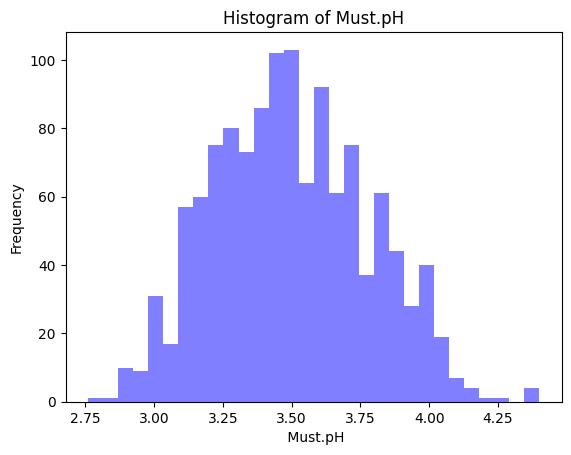

In [349]:
values_to_plot = copie[tested]

# Create the histogram
plt.hist(values_to_plot, bins=30, color='blue', alpha=0.5)

# Set the title and axis labels
plt.title(f'Histogram of {tested}')
plt.xlabel(f' {tested}')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [350]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [351]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), temperatures.columns)  
    ],
    remainder='passthrough' 
)

exp_models = {}


In [352]:
scorers = {
    'mse': make_scorer(mean_squared_error, squared = False, greater_is_better=False),
    'r2': make_scorer(r2_score)
}


cv = KFold(n_splits=5, shuffle=True, random_state=42)

#linear regression avec lasso et ridge 
alphas = loguniform(1e-5, 2e1)

param_dist = {'mod__alpha': alphas}

pLasso = Pipeline([
    ('preprocessor', preprocessor),
    ('mod', Lasso())
])

pRidge = Pipeline([
    ('preprocessor', preprocessor),
    ('mod', Ridge())
])

rand_lass = RandomizedSearchCV(pLasso, param_distributions=param_dist, scoring=scorers, refit='mse',verbose=1, n_iter=40, cv=cv, random_state=7)
rand_rid = RandomizedSearchCV(pRidge, param_distributions=param_dist, scoring=scorers, refit='mse',verbose=1, n_iter=40, cv=cv, random_state=7)


rand_lass.fit(X_train, y_train.values.ravel())
rand_rid.fit(X_train, y_train.values.ravel())

exp_models["rand_lass"]=rand_lass
exp_models["rand_rid"]=rand_rid


print("Best hyperparameters: ", rand_lass.best_params_)
print("Cross-validation score: ", rand_lass.best_score_)

print("Best hyperparameters: ", rand_rid.best_params_)
print("Cross-validation score: ", rand_rid.best_score_)



Fitting 5 folds for each of 40 candidates, totalling 200 fits


/home/amelie/Documents/Cours Dauphine/M1/S2/projet_ml/projet_wine/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.689e+00, tolerance: 6.277e-03
  model = cd_fast.enet_coordinate_descent(
/home/amelie/Documents/Cours Dauphine/M1/S2/projet_ml/projet_wine/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.205e+00, tolerance: 6.271e-03
  model = cd_fast.enet_coordinate_descent(
/home/amelie/Documents/Cours Dauphine/M1/S2/projet_ml/projet_wine/env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did no

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best hyperparameters:  {'mod__alpha': 0.00202062767050333}
Cross-validation score:  -0.2311937591896554
Best hyperparameters:  {'mod__alpha': 14.532530748788867}
Cross-validation score:  -0.23125516101055849


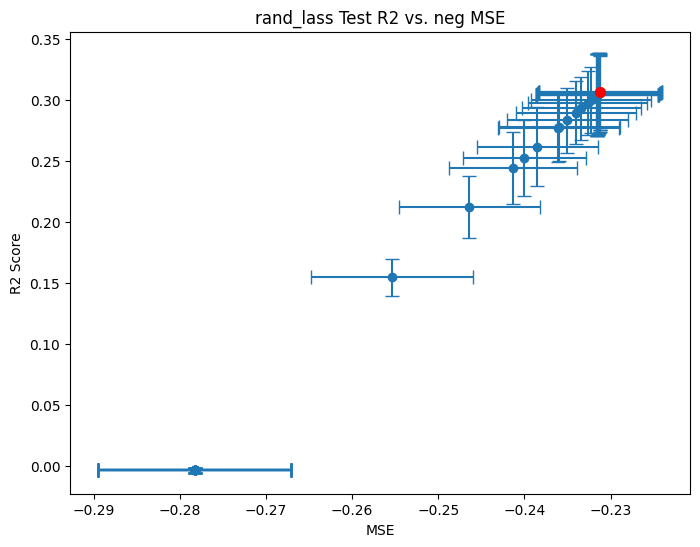

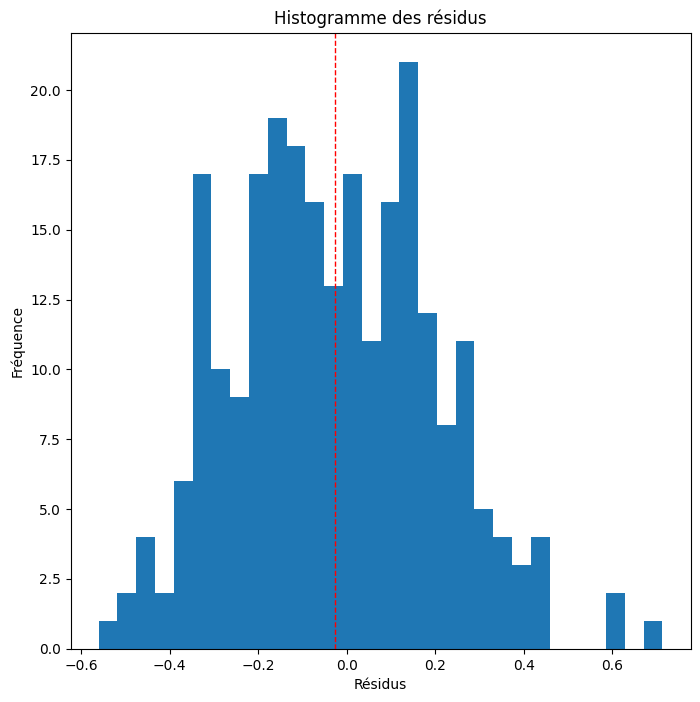

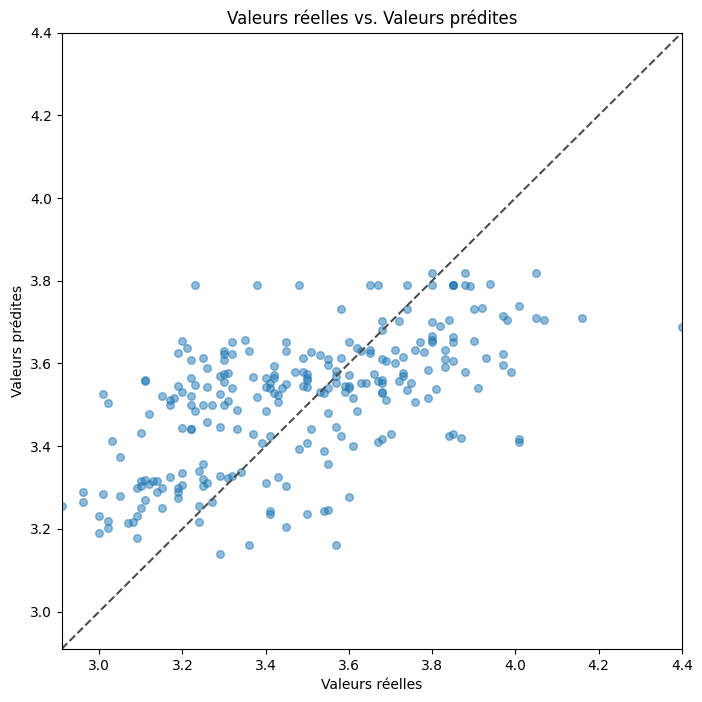

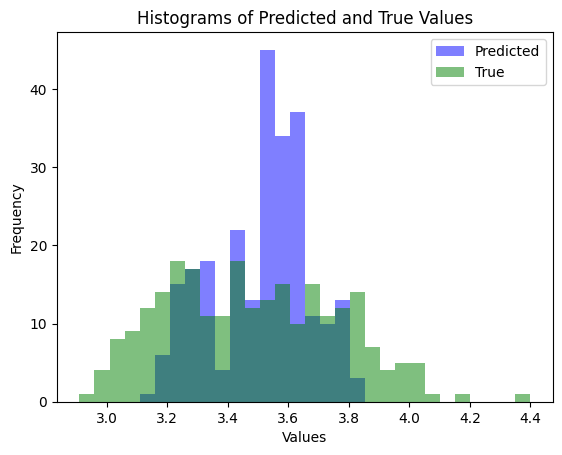

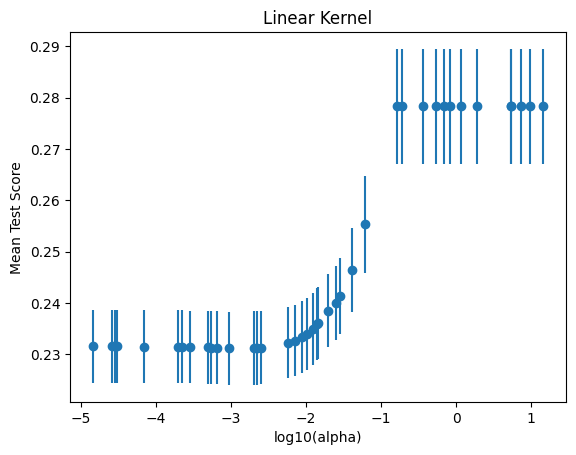

In [353]:
predicted_values = rand_lass.predict(X_test)
true_values = y_test[tested]

plot_scores("rand_lass")
plot_residuals(true_values,predicted_values)
plot_true_vs_predicted(true_values,predicted_values)
plot_hists(true_values,predicted_values)
trend_param_log("rand_lass", 'alpha')

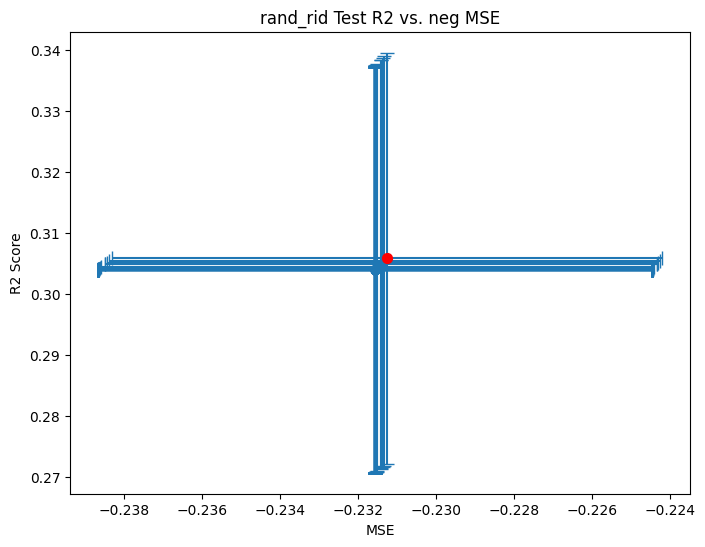

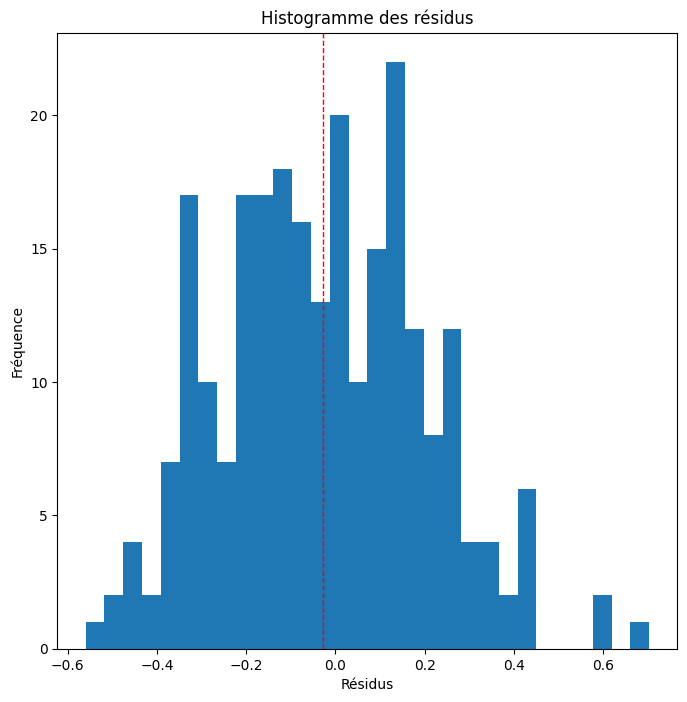

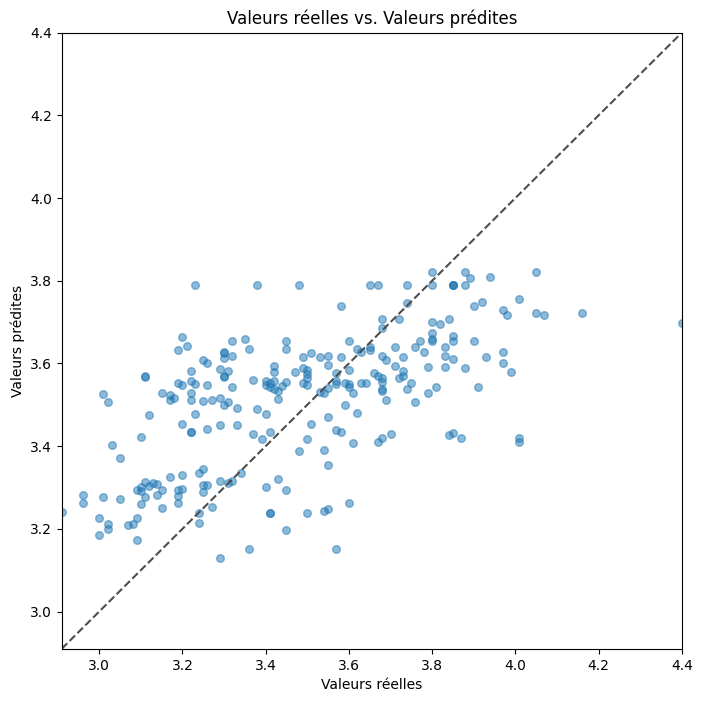

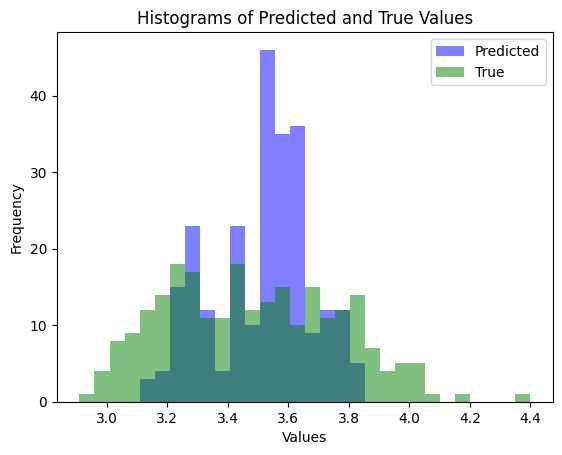

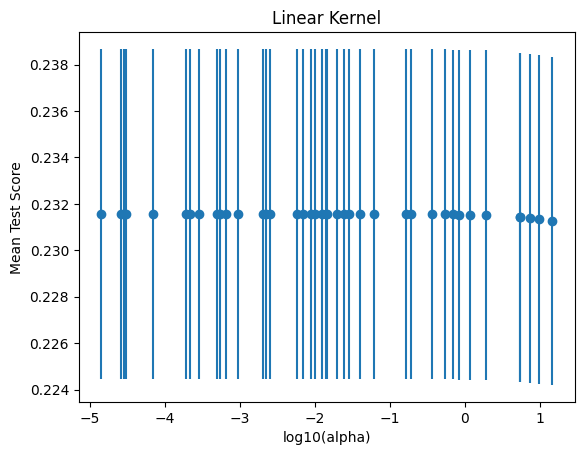

In [354]:
predicted_values = rand_rid.predict(X_test)
true_values = y_test[tested]

plot_scores("rand_rid")
plot_residuals(true_values,predicted_values)
plot_true_vs_predicted(true_values,predicted_values)
plot_hists(true_values,predicted_values)
trend_param_log("rand_rid", 'alpha')

In [355]:
param_dist_kr = {'mod__alpha': loguniform(1e-1, 5e1),
            'mod__gamma': loguniform(1e-4, 1e-1),
            'mod__kernel':['linear', 'poly', 'rbf', 'laplacian']}
#removed sigmoid because performance has too much variability and is no good

pKerR = Pipeline([
    ('preprocessor', preprocessor),
    ('mod', KernelRidge())
])


rand_KerR = RandomizedSearchCV(pKerR, param_distributions=param_dist_kr, scoring=scorers, refit='mse',verbose=1, n_iter=50, cv=cv, random_state=7)

rand_KerR.fit(X_train, y_train.values.ravel())
exp_models["rand_KerR"]=rand_KerR
print("Best hyperparameters: ", rand_KerR.best_params_)
print("Cross-validation score: ", rand_KerR.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters:  {'mod__alpha': 0.16067702577921045, 'mod__gamma': 0.021865347140571714, 'mod__kernel': 'laplacian'}
Cross-validation score:  -0.19578910427781193


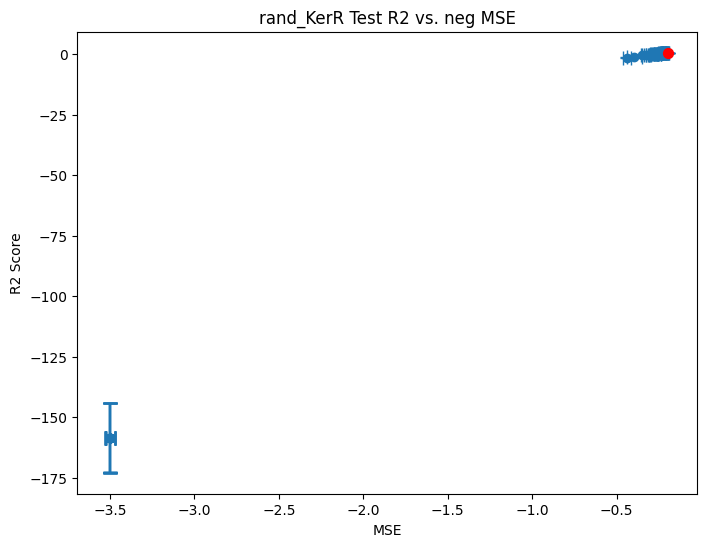

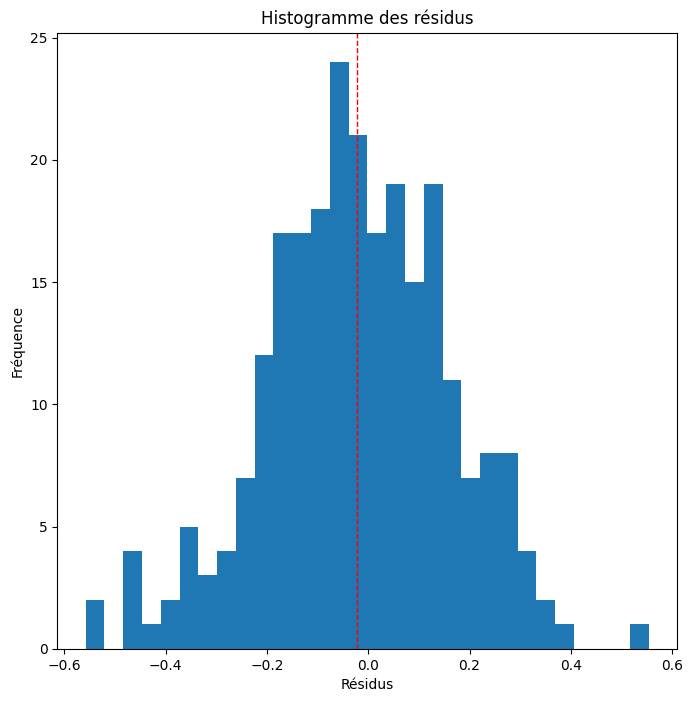

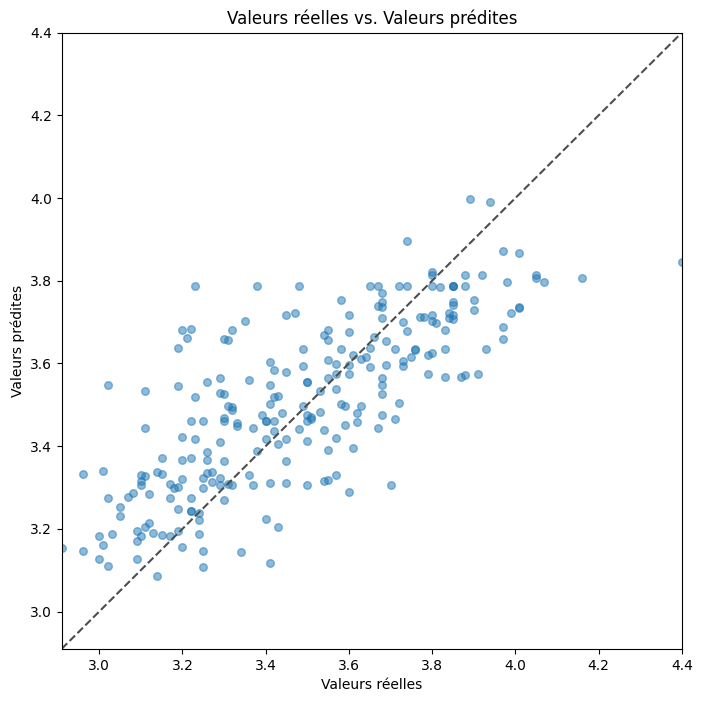

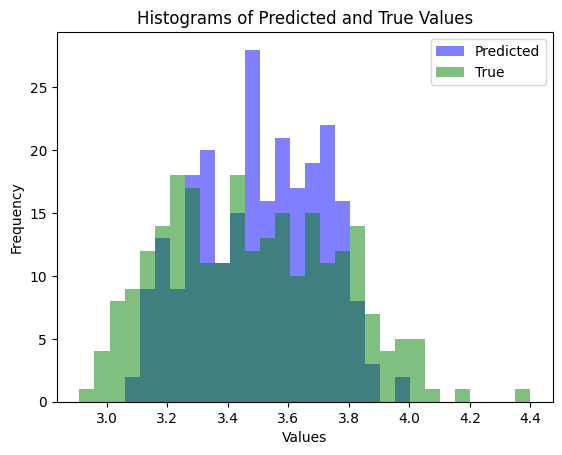

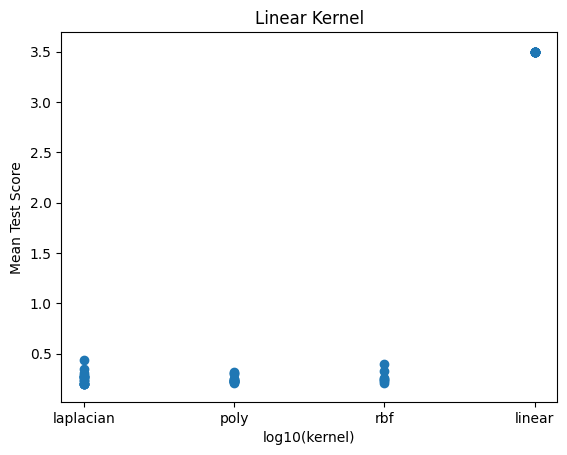

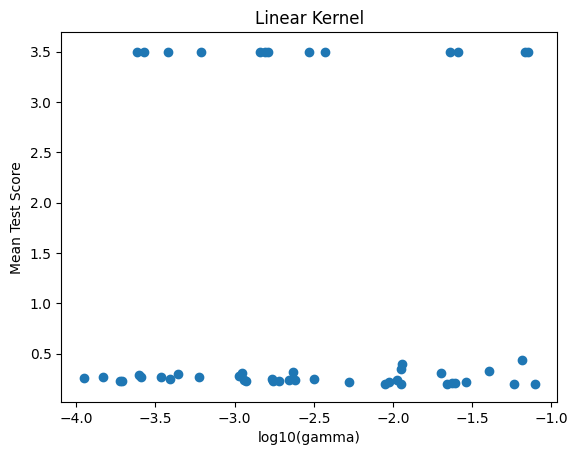

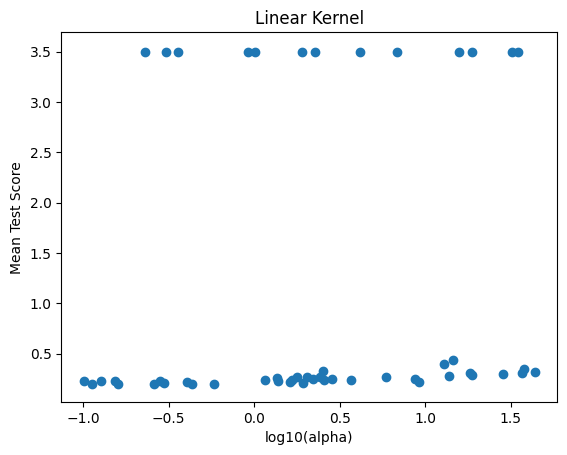

In [356]:
predicted_values = rand_KerR.predict(X_test)
true_values = y_test[tested]

plot_scores("rand_KerR")
plot_residuals(true_values,predicted_values)
plot_true_vs_predicted(true_values,predicted_values)
plot_hists(true_values,predicted_values)
trend_param("rand_KerR", 'kernel')
trend_param_log("rand_KerR", 'gamma')
trend_param_log("rand_KerR", 'alpha')

In [357]:
pSVRlin = Pipeline([
    ('preprocessor', preprocessor),
    ('mod', SVR(kernel='linear'))
])

param_dist_lin = {'mod__C': loguniform(1e-4, 1e1), 
              'mod__epsilon': loguniform(1e-3, 1)}

rand_lin = RandomizedSearchCV(pSVRlin, param_distributions=param_dist_lin, scoring=scorers, refit='mse',verbose=1, n_iter=20, cv=cv, random_state=7)

rand_lin.fit(X_train, y_train.values.ravel())
exp_models["rand_lin"]=rand_lin
print("Best hyperparameters: ", rand_lin.best_params_)
print("Cross-validation score: ", rand_lin.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters:  {'mod__C': 0.006752303101068001, 'mod__epsilon': 0.3264028806408864}
Cross-validation score:  -0.23096452783742402


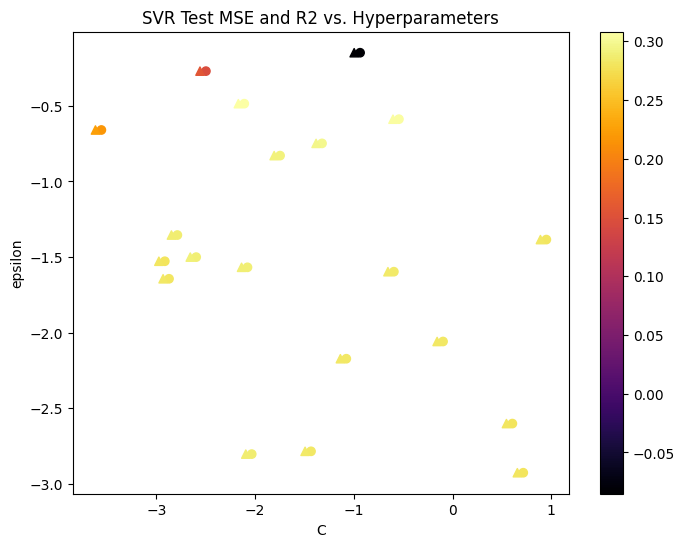

In [358]:
C_values = rand_lin.cv_results_['param_mod__C'].data
epsilon_values = rand_lin.cv_results_['param_mod__epsilon'].data
mean_test_scores = rand_lin.cv_results_['mean_test_mse']
mean_test_r2_scores = rand_lin.cv_results_['mean_test_r2']

plt.figure(figsize=(8, 6))
plt.scatter(np.array([np.log10(float(c))+0.06 for c in C_values]), np.array([np.log10(float(e)) for e in epsilon_values]), c=mean_test_scores, cmap='inferno', marker='o')
plt.scatter(np.array([np.log10(float(c)) for c in C_values]), np.array([np.log10(float(e)) for e in epsilon_values]), c=mean_test_r2_scores, cmap='inferno', marker='^')
plt.colorbar()
plt.xlabel('C')
plt.ylabel('epsilon')
plt.title('SVR Test MSE and R2 vs. Hyperparameters')
plt.show()

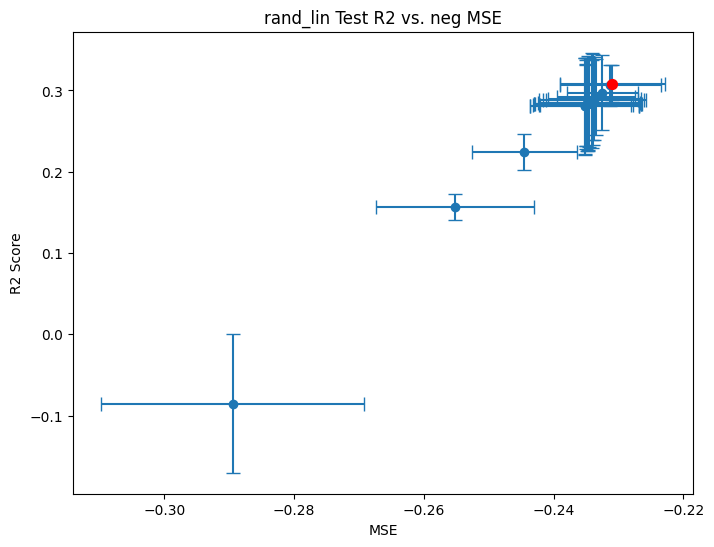

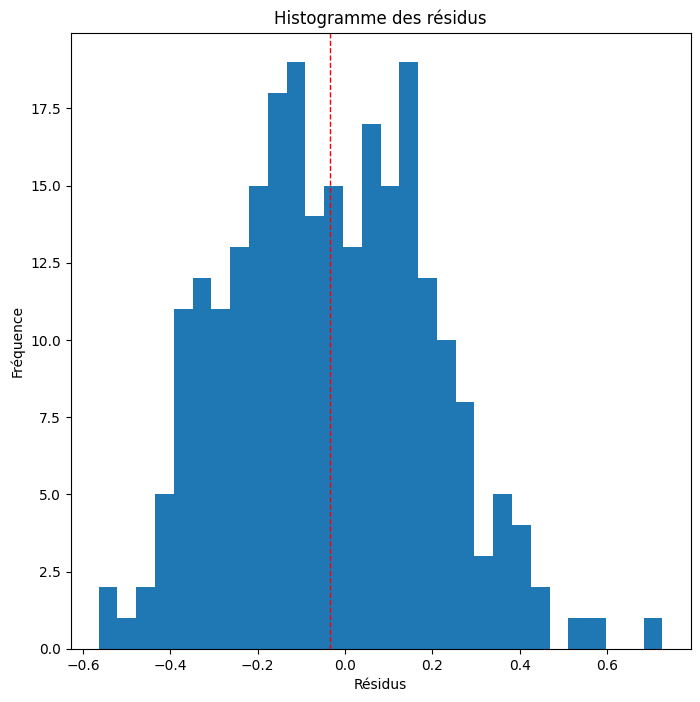

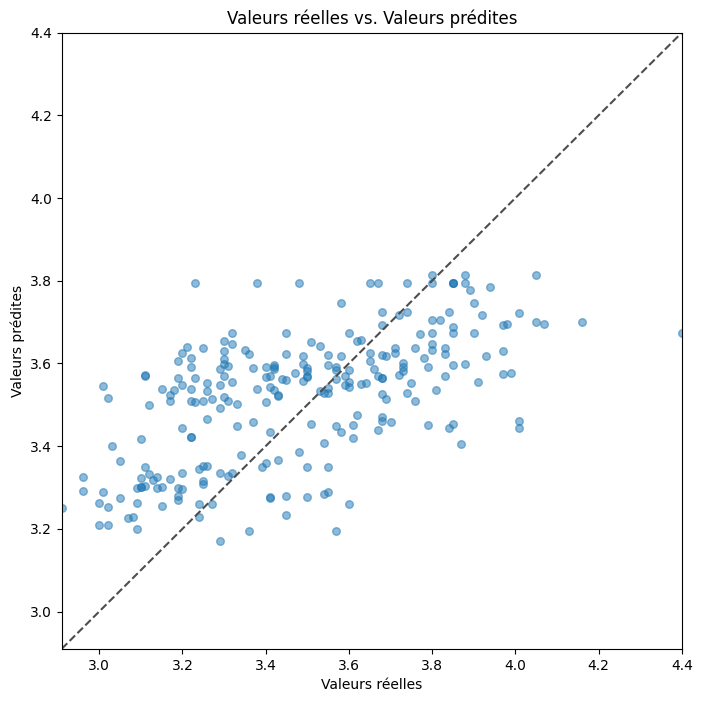

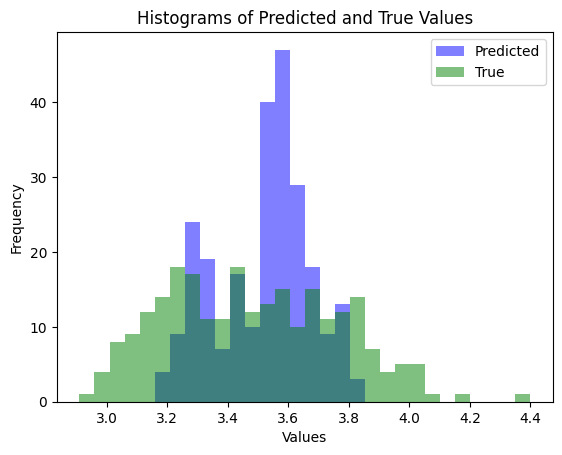

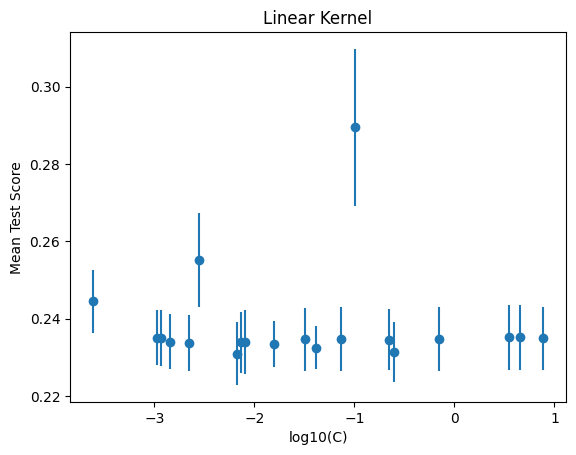

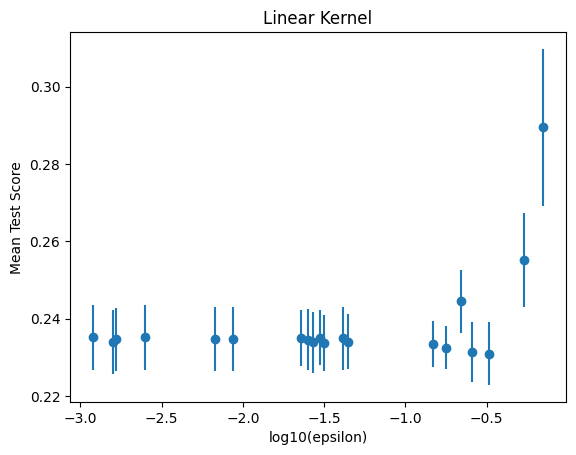

In [359]:
predicted_values = rand_lin.predict(X_test)
true_values = y_test[tested]

plot_scores("rand_lin")
plot_residuals(true_values,predicted_values)
plot_true_vs_predicted(true_values,predicted_values)
plot_hists(true_values,predicted_values)
trend_param_log("rand_lin", 'C')
trend_param_log("rand_lin", 'epsilon')

In [360]:
pSVRrbf = Pipeline([
    ('preprocessor', preprocessor),
    ('mod', SVR(kernel='rbf'))
])


param_dist_rbf = {'mod__C': loguniform(1e-4, 1e1), 
              'mod__epsilon': loguniform(1e-3, 1),
                  'mod__gamma': ['scale', 'auto']}

rand_rbf = RandomizedSearchCV(pSVRrbf, param_distributions=param_dist_rbf, 
                              scoring=scorers, refit='mse', verbose=1, cv=cv,
                              n_iter=20, random_state=7)

rand_rbf.fit(X_train, y_train.values.ravel())
exp_models["rand_rbf"]=rand_rbf
print("Best hyperparameters: ", rand_rbf.best_params_)
print("Cross-validation score: ", rand_rbf.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters:  {'mod__C': 1.5473550318638924, 'mod__epsilon': 0.2022751442509898, 'mod__gamma': 'auto'}
Cross-validation score:  -0.19963701527407499


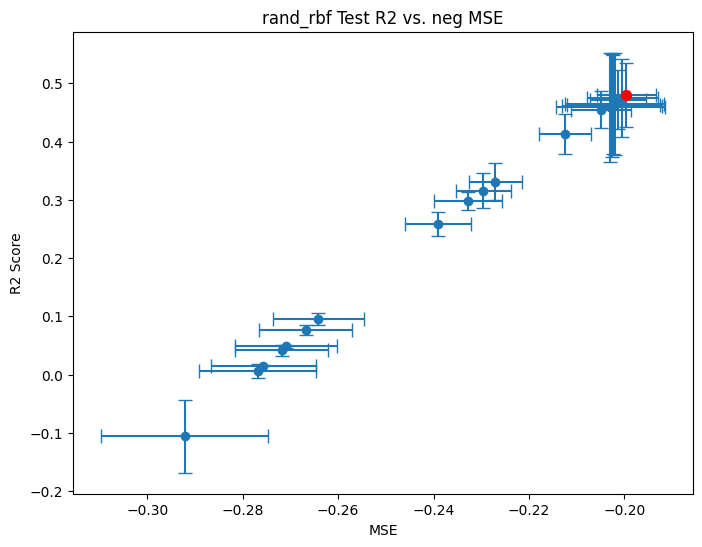

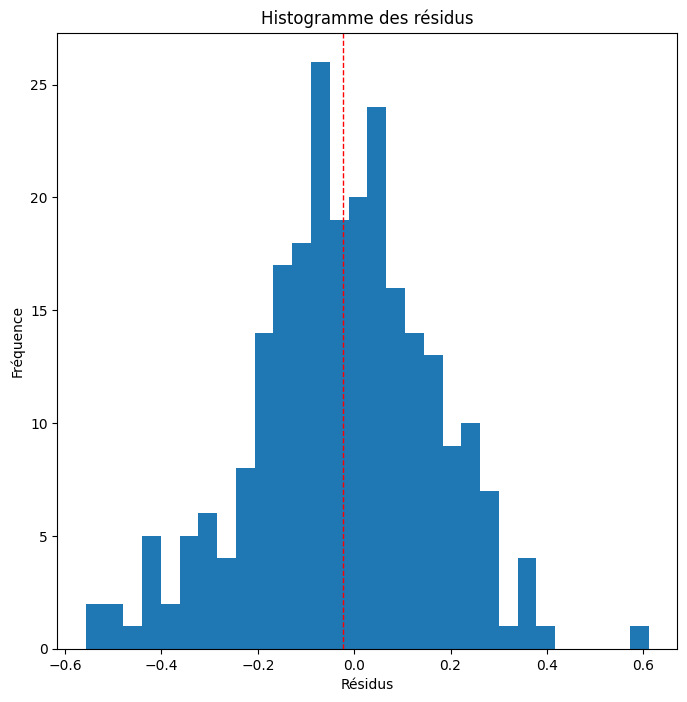

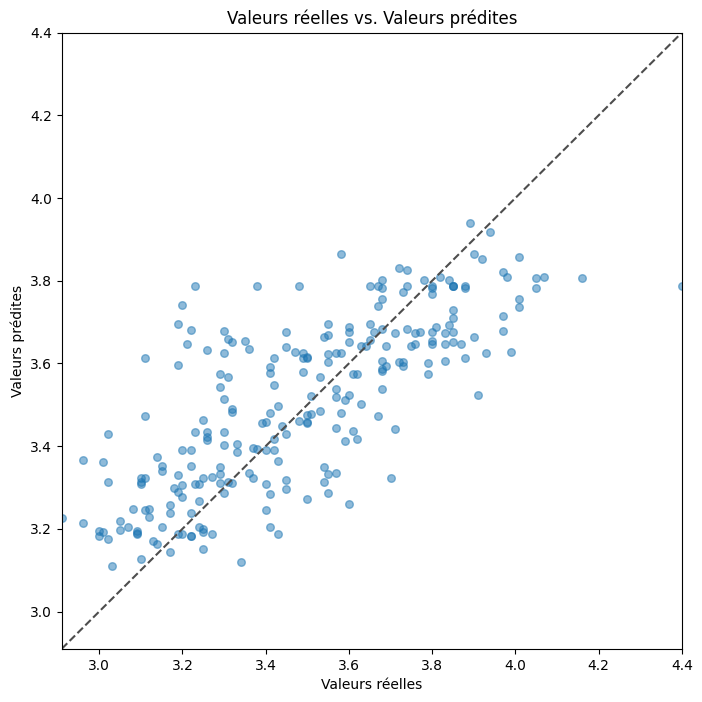

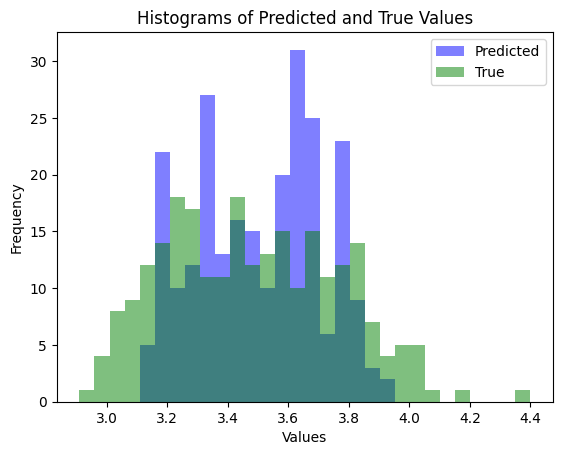

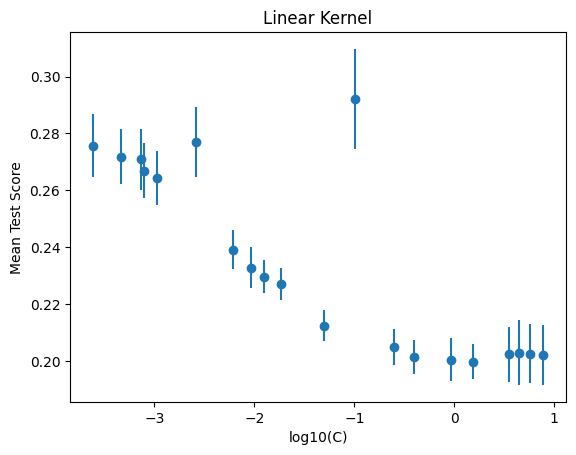

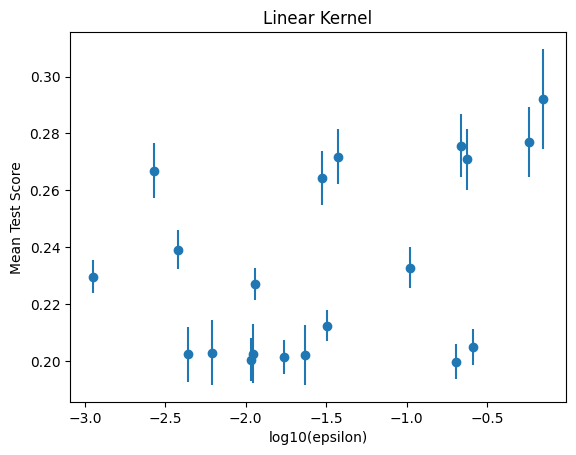

In [361]:
predicted_values = rand_rbf.predict(X_test)
true_values = y_test[tested]

plot_scores("rand_rbf")
plot_residuals(true_values,predicted_values)
plot_true_vs_predicted(true_values,predicted_values)
plot_hists(true_values,predicted_values)
trend_param_log("rand_rbf", 'C')
trend_param_log("rand_rbf", 'epsilon')

In [362]:
pSVRpoly = Pipeline([
    ('preprocessor', preprocessor),
    ('mod', SVR(kernel='poly'))
])

param_dist_poly = {'mod__C': loguniform(1e-4, 1e1), 
              'mod__epsilon': loguniform(1e-3, 1),
                   'mod__degree':[2,3,4,5,6,7]}

rand_poly = RandomizedSearchCV(pSVRpoly, param_distributions=param_dist_poly, 
                                 n_iter=20, scoring=scorers, refit='mse', 
                                 verbose=1, cv=cv, random_state=7)

rand_poly.fit(X_train, y_train.values.ravel())
exp_models["rand_poly"]=rand_poly
print("Best hyperparameters: ", rand_poly.best_params_)
print("Cross-validation score: ", rand_poly.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters:  {'mod__C': 1.8049822333059238, 'mod__degree': 3, 'mod__epsilon': 0.044204833356897774}
Cross-validation score:  -0.20310938302750287


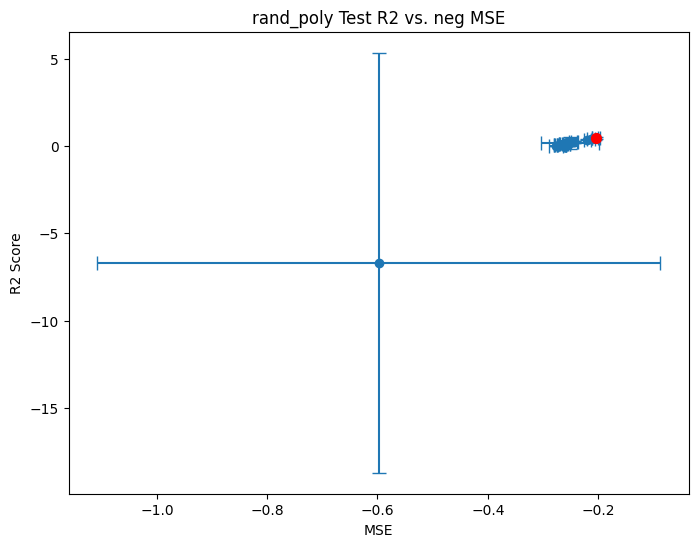

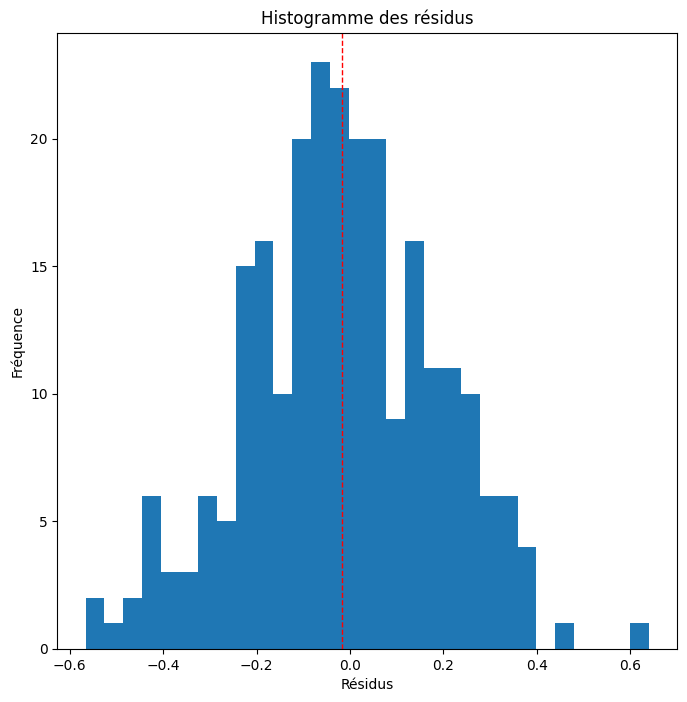

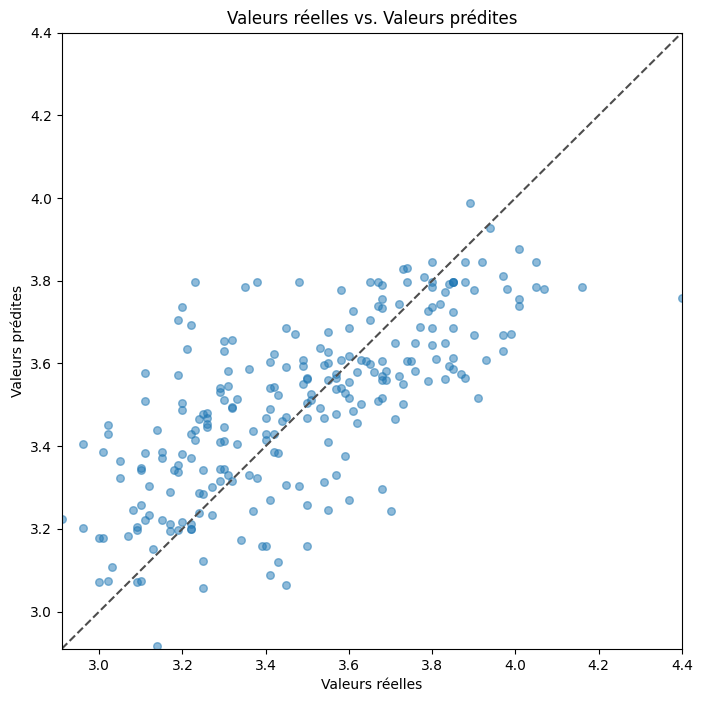

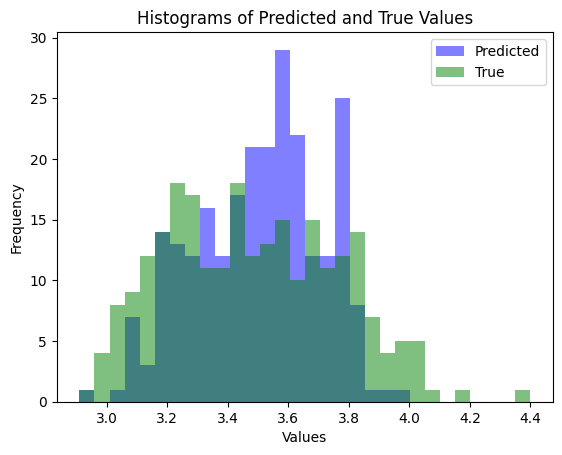

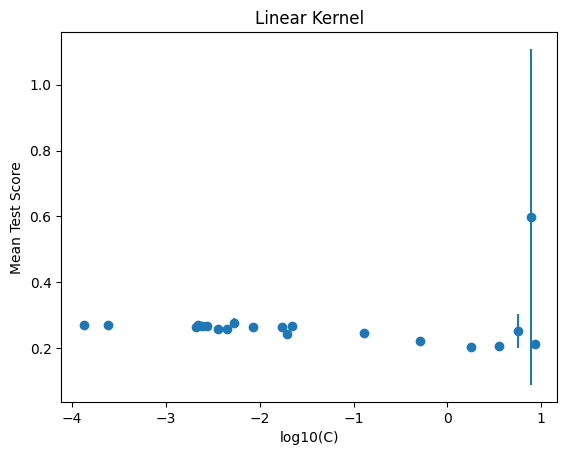

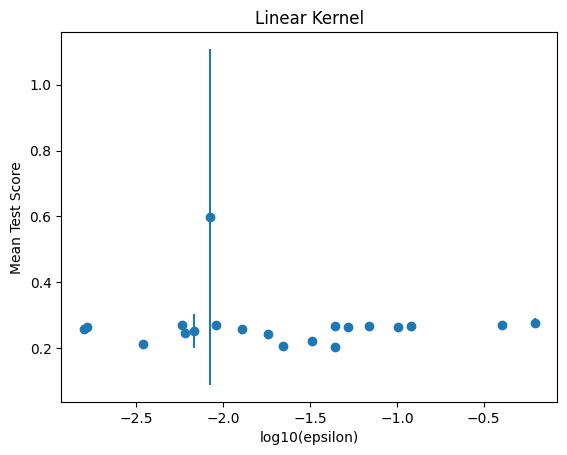

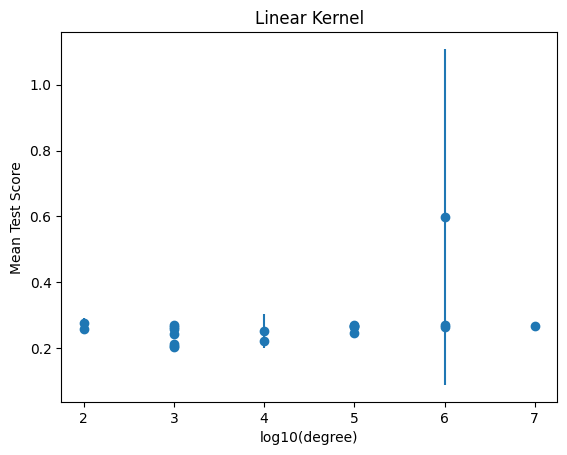

In [363]:
predicted_values = rand_poly.predict(X_test)
true_values = y_test[tested]

plot_scores("rand_poly")
plot_residuals(true_values,predicted_values)
plot_true_vs_predicted(true_values,predicted_values)
plot_hists(true_values,predicted_values)
trend_param_log("rand_poly", 'C')
trend_param_log("rand_poly", 'epsilon')
trend_param("rand_poly", 'degree')

In [364]:
pSVRsigmoid = Pipeline([
    ('preprocessor', preprocessor),
    ('mod', SVR(kernel='sigmoid'))
])


param_grid_sig = {'mod__C': loguniform(1e-5, 5e-2), 
              'mod__epsilon': loguniform(1e-4, 1)}

rand_sig = RandomizedSearchCV(pSVRsigmoid, param_distributions=param_grid_sig,
                              scoring=scorers, refit='mse', verbose=1, cv=cv, n_iter=20,random_state=7)

rand_sig.fit(X_train, y_train.values.ravel())
exp_models["rand_sig"]=rand_sig
print("Best hyperparameters: ", rand_sig.best_params_)
print("Cross-validation score: ", rand_sig.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters:  {'mod__C': 0.00696953928684168, 'mod__epsilon': 0.0018029293506528518}
Cross-validation score:  -0.24668978993260166


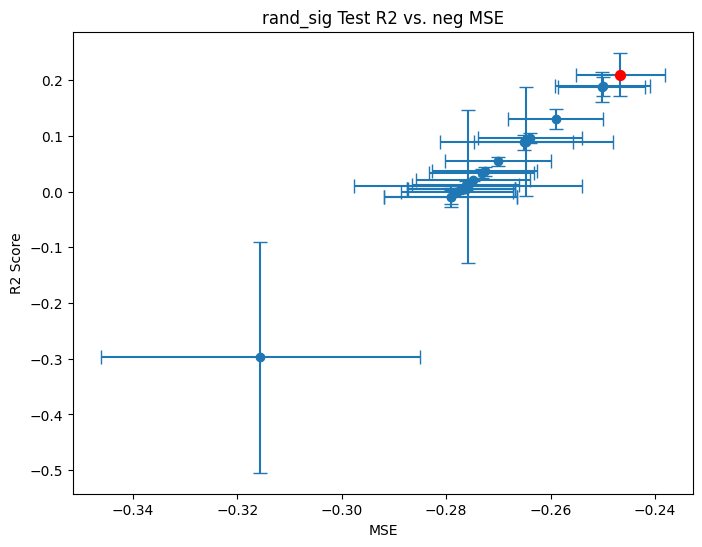

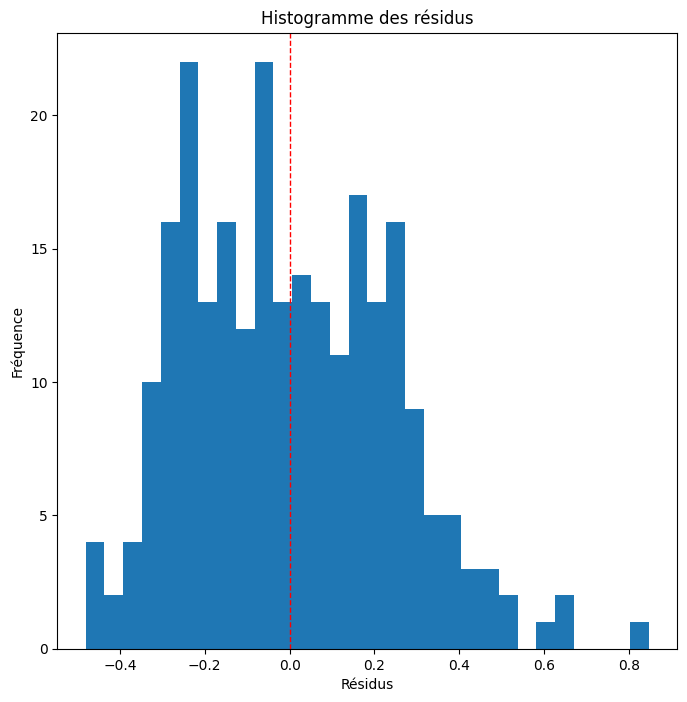

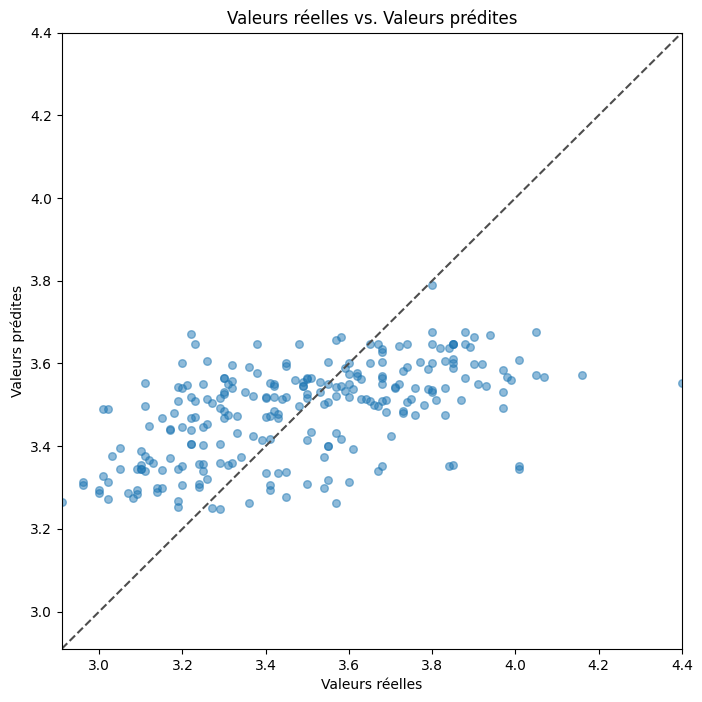

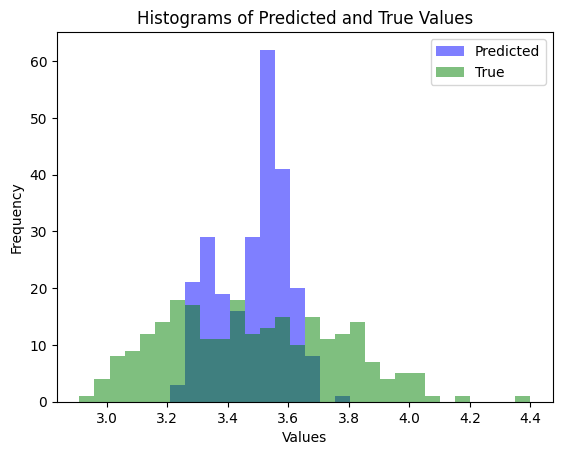

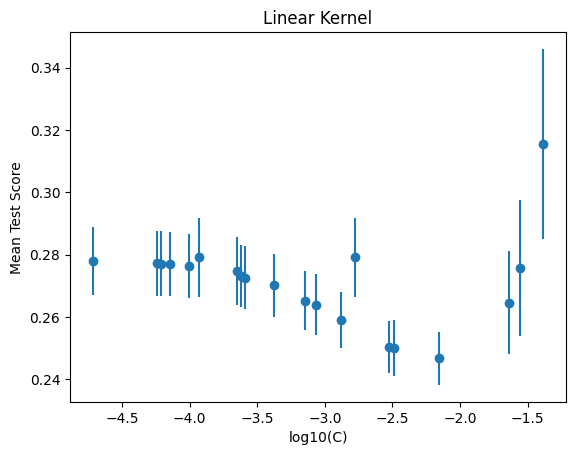

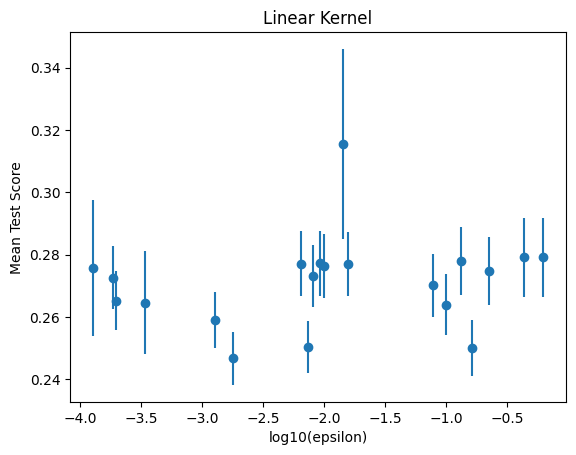

In [365]:
predicted_values = rand_sig.predict(X_test)
true_values = y_test[tested]

plot_scores("rand_sig")
plot_residuals(true_values,predicted_values)
plot_true_vs_predicted(true_values,predicted_values)
plot_hists(true_values,predicted_values)
trend_param_log("rand_sig", 'C')
trend_param_log("rand_sig", 'epsilon')

In [366]:
pRT = Pipeline([
    ('preprocessor', preprocessor),
    ('mod', RandomForestRegressor())
])

param_dist_rt = {
    'mod__n_estimators': [10, 50, 100],
    'mod__max_depth': [2, 4, 6, None],
    'mod__min_samples_split': [2, 5, 10],
    'mod__min_samples_leaf': [1, 2, 4],
}


rand_rt = RandomizedSearchCV(estimator=pRT, param_distributions=param_dist_rt, 
                             n_iter=20, cv=cv, random_state=7, 
                             scoring=scorers, refit='mse', verbose=1)

rand_rt.fit(X_train, y_train.values.ravel())
exp_models["rand_rt"]=rand_rt
print("Best hyperparameters:", rand_rt.best_params_)
print("Best cross-validation score:", rand_rt.best_score_)



Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best hyperparameters: {'mod__n_estimators': 100, 'mod__min_samples_split': 2, 'mod__min_samples_leaf': 4, 'mod__max_depth': None}
Best cross-validation score: -0.19579252166595365


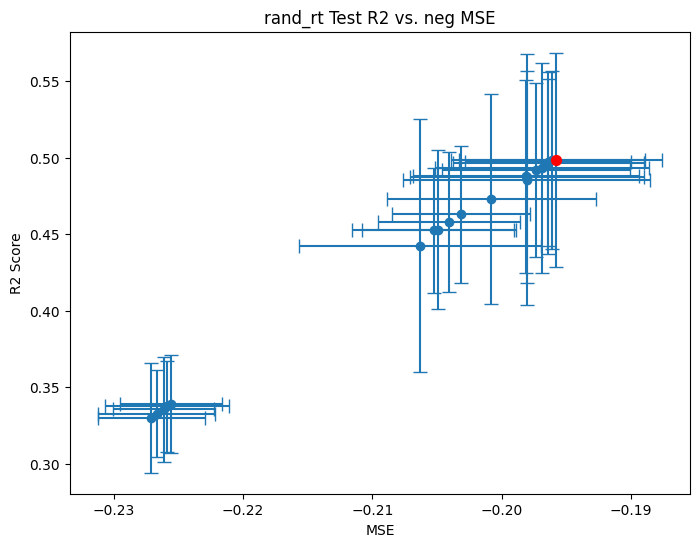

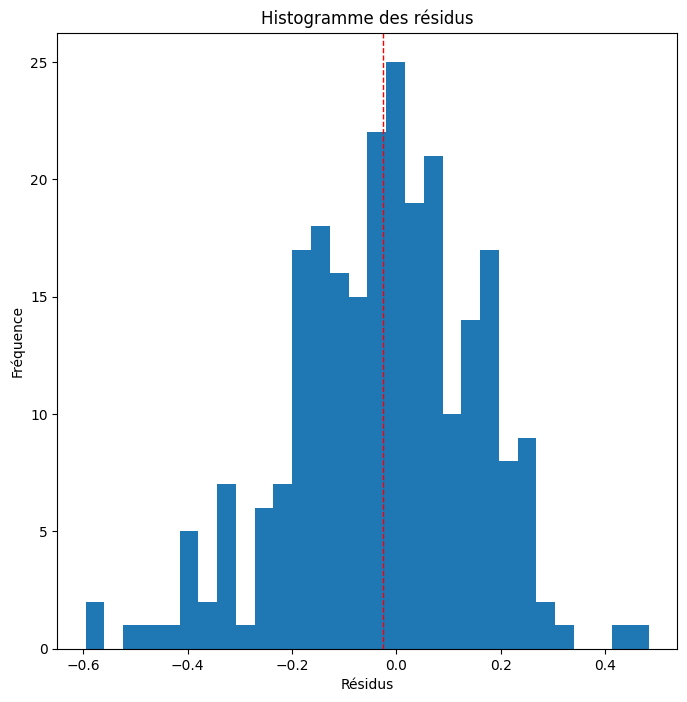

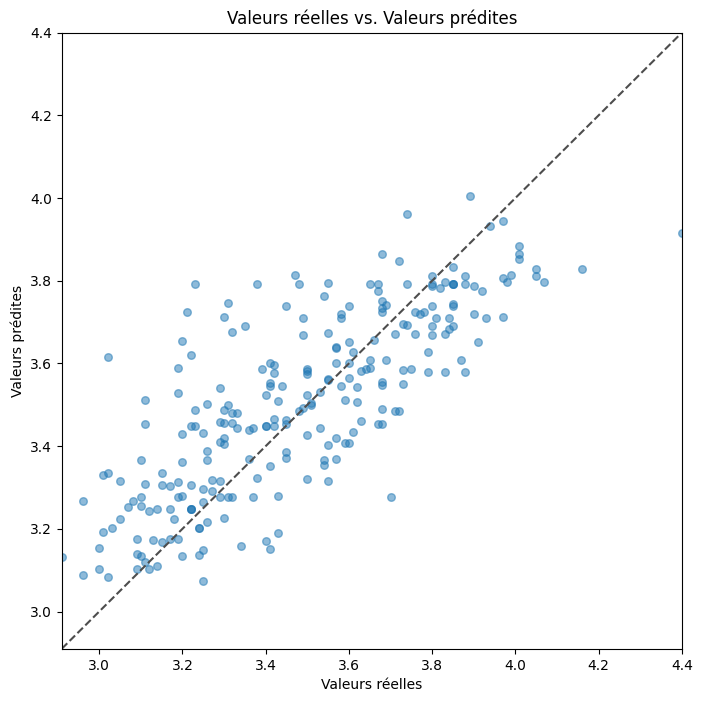

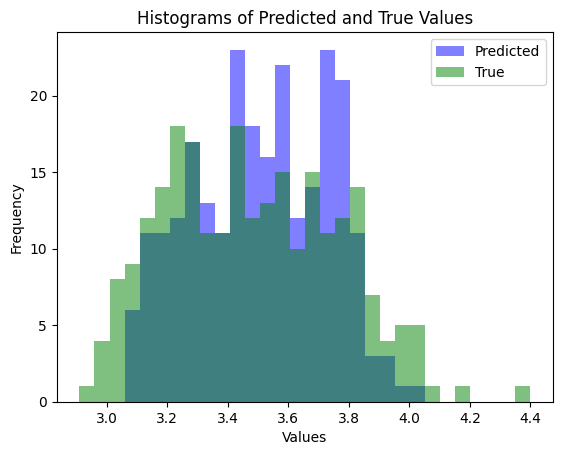

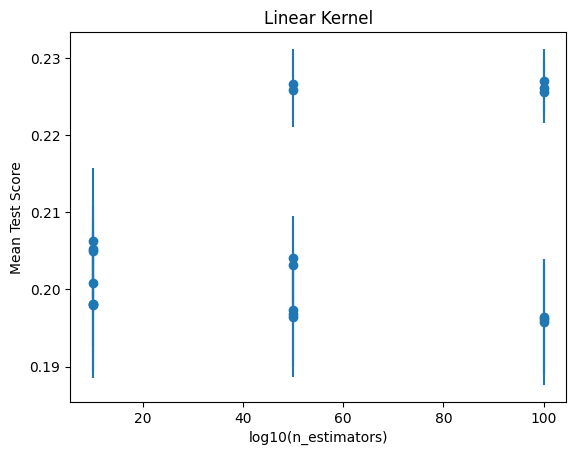

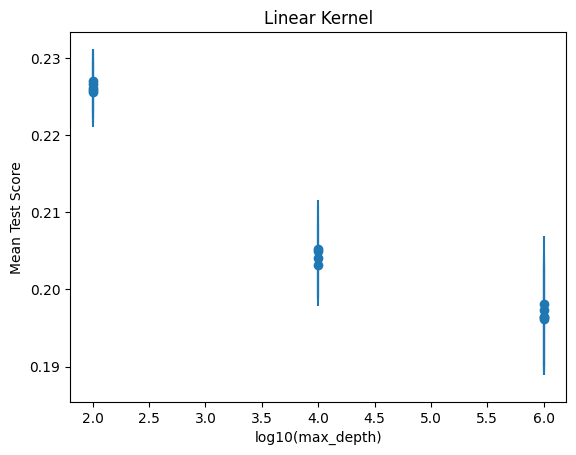

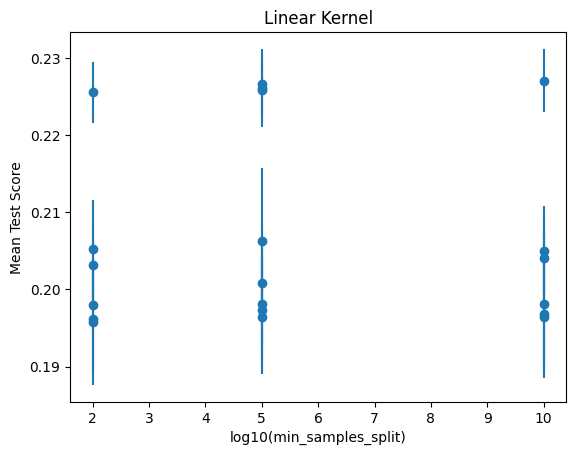

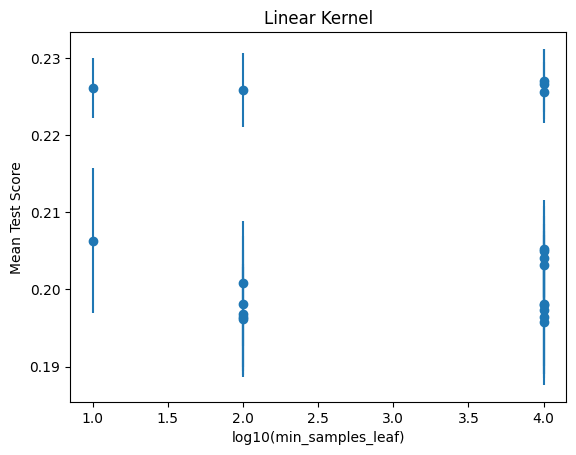

In [367]:
predicted_values = rand_rt.predict(X_test)
true_values = y_test[tested]

plot_scores("rand_rt")
plot_residuals(true_values,predicted_values)
plot_true_vs_predicted(true_values,predicted_values)
plot_hists(true_values,predicted_values)
trend_param("rand_rt", 'n_estimators')
trend_param("rand_rt", 'max_depth')
trend_param("rand_rt", 'min_samples_split')
trend_param("rand_rt", 'min_samples_leaf')

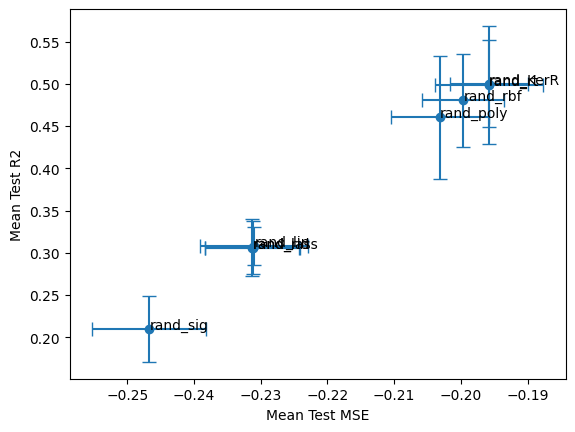

In [368]:
mse_scores = []
mse_err = []
r2_scores = []
r2_err = []
model_names = []

for key, model in exp_models.items():
    mse_scores.append(model.cv_results_['mean_test_mse'][model.best_index_])
    r2_scores.append(model.cv_results_['mean_test_r2'][model.best_index_])
    mse_err.append(model.cv_results_['std_test_mse'][model.best_index_])
    r2_err.append(model.cv_results_['std_test_r2'][model.best_index_])
    model_names.append(key)

fig, ax = plt.subplots()
plt.errorbar(mse_scores, r2_scores, xerr = mse_err ,yerr=r2_err, fmt='o', capsize=5)
for i, txt in enumerate(model_names):
    ax.annotate(txt, (mse_scores[i], r2_scores[i]))
ax.set_xlabel('Mean Test MSE')
ax.set_ylabel('Mean Test R2')
plt.show()

In [369]:
mse_scores

[-0.2311937591896554,
 -0.23125516101055849,
 -0.19578910427781193,
 -0.23096452783742402,
 -0.19963701527407499,
 -0.20310938302750287,
 -0.24668978993260166,
 -0.19579252166595365]

In [370]:
model_data = [(model_names[i], mse_scores[i],mse_err[i],r2_scores[i],r2_err[i]) for i in range(len(model_names))]
sorted_model_data = sorted(model_data, key=lambda x: x[1], reverse=True)
models_sorted = pd.DataFrame(sorted_model_data, columns=['Model Name', 'MSE Score', 'MSE std ', 'R2 score', 'R2 std'])
display(models_sorted)

,Model Name,MSE Score,MSE std,R2 score,R2 std
0,rand_KerR,-0.195789,0.005818,0.500324,0.051689
1,rand_rt,-0.195793,0.008150,0.498502,0.069954
2,rand_rbf,-0.199637,0.006162,0.480401,0.054600
3,rand_poly,-0.203109,0.007295,0.460335,0.072820
4,rand_lin,-0.230965,0.008080,0.308181,0.022718
5,rand_lass,-0.231194,0.007149,0.306313,0.031052
6,rand_rid,-0.231255,0.007050,0.305798,0.033693
7,rand_sig,-0.246690,0.008522,0.210238,0.039272


In [371]:
best_model_name = model_names[mse_scores.index(max(mse_scores))]
best_model = exp_models[model_names[mse_scores.index(max(mse_scores))]]

y_pred = best_model.predict(X_test)
y_true = y_test.values.ravel()
mse = np.mean((y_true- y_pred) ** 2)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
y_range = np.max(y_true) - np.min(y_true)

print(tested)
print(best_model_name)
print('* relative MAE:', mae/y_range)
print('* R²:', r2)

print("* relative RMSE", rmse/y_range)

print("* MSE", mse)

Must.pH
rand_KerR
* relative MAE: 0.09753409700493643
* R²: 0.5837729962870721
* relative RMSE 0.12333300950807016
* MSE 0.03377001044330879


## Must.pH with different dataset :
# agg_all_temp with n=10
rand_KerR
* relative MAE: 0.09761194638445561
* R²: 0.4894249982822234
* relative RMSE 0.12368571909001934
* MSE 0.04014848351112575

# agg_all_temp with n=5
rand_KerR
* relative MAE: 0.09567778370207457
* R²: 0.49286116463584706
* relative RMSE 0.1232688144325116
* MSE 0.03987828448507512

# all_temp
rand_KerR
* relative MAE: 0.09771021728077621
* R²: 0.4566368670947023
* relative RMSE 0.12759535622723434
* MSE 0.042726740848272986

# int_all_temp (le meilleur)
rand_rt
* relative MAE: 0.0944972426840638
* R²: 0.6000868986336655
* relative RMSE 0.12089184865037178
* MSE 0.03244640421953878
# both_over 
rand_rt
* relative MAE: 0.09452942198285176
* R²: 0.5903610976154006
* relative RMSE 0.12235304993247882
* MSE 0.033235493824553625

## pour vins white  :
# Must.pH avec over_both
rand_rt
* relative MAE: 0.13165260392304265
* R²: 0.3918709285000739
* relative RMSE 0.1709200329776504
* MSE 0.04419734269360437

# Wine.tanin
rand_KerR
* relative MAE: 0.14417251728089683
* R²: 0.3343206642107607
* relative RMSE 0.19475622195329392
* MSE 0.0001858569313486514

## pour vins red  :
# Must.pH avec over_both
rand_rt
* relative MAE: 0.09988219040965014
* R²: 0.523864557690737
* relative RMSE 0.1298941036379844
* MSE 0.03450253058921105

# Wine.tanin
rand_KerR
* relative MAE: 0.12317021144796764
* R²: 0.09504619054154462
* relative RMSE 0.16539693128874816
* MSE 0.004160869636207676

## avec hashing features
# pH with both over 
rand_KerR
* relative MAE: 0.09023556422021284
* R²: 0.6470183277388004
* relative RMSE 0.11357697063615182
* MSE 0.028638686707551247

# Wine.Tannin with both over 
rand_rt
* relative MAE: 0.0857755946944062
* R²: 0.6017799574431195
* relative RMSE 0.12375165696526144
* MSE 0.0022114098436779336

I accept some data leak in my RFE because the class in sklearn is built to receive a dataframe and my datascaler looses that shape. A more rigorous approach would be to perform the cross validation by hand.

In [372]:
from sklearn.feature_selection import RFECV

Xcop = X_train.copy()
clm = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), temperatures.columns)  
    ],
    remainder='passthrough' 
)
Xcop = clm.fit_transform(Xcop)
Xcop = pd.DataFrame(Xcop, columns = X_train.columns)


selector = RFECV(rand_rt.best_estimator_.named_steps['mod'], step=1, scoring='neg_mean_squared_error', cv=5, min_features_to_select=1)
selector.fit(Xcop, y_train.values.ravel())

RFECV(cv=5, estimator=RandomForestRegressor(min_samples_leaf=4),
      scoring='neg_mean_squared_error')

In [373]:
Xcop = X_train.copy()
clm = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), temperatures.columns)  
    ],
    remainder='passthrough' 
)
Xcop = clm.fit_transform(Xcop)
Xcop = pd.DataFrame(Xcop, columns = X_train.columns)


selector_lass = RFECV(rand_lass.best_estimator_.named_steps['mod'], step=1, scoring='neg_mean_squared_error', cv=5, min_features_to_select=1)
selector_lass.fit(Xcop, y_train.values.ravel())


RFECV(cv=5, estimator=Lasso(alpha=0.00202062767050333),
      scoring='neg_mean_squared_error')

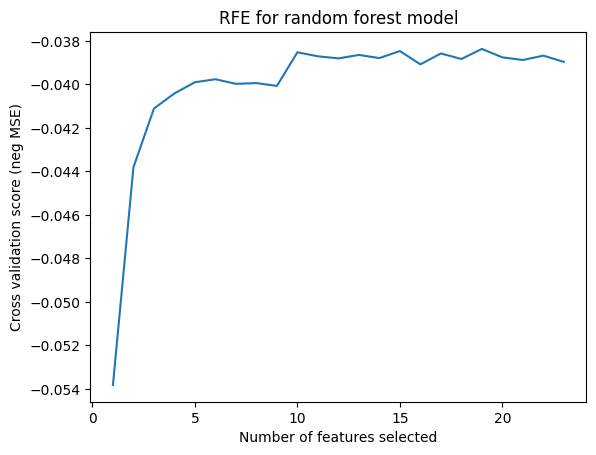

In [374]:
scores = selector.cv_results_['mean_test_score']

# Plot the scores against number of features
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (neg MSE)")
plt.title("RFE for random forest model")
plt.plot(range(1, len(scores) + 1), scores)
plt.show()


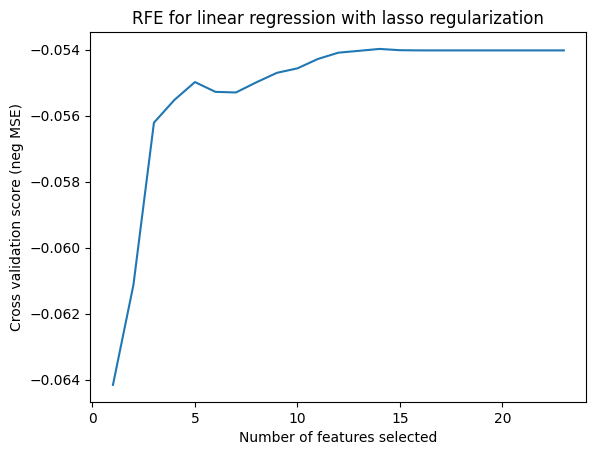

In [375]:
scores = selector_lass.cv_results_['mean_test_score']

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (neg MSE)")
plt.title("RFE for linear regression with lasso regularization")
plt.plot(range(1, len(scores) + 1), scores)
plt.show()

In [376]:
mask = selector.support_
selected_features = X.columns[mask]
print("rfe random forests" ,selected_features)

rfe random forests Index(['1intervalle_-5-0', '1intervalle_0-5', '1intervalle_5-10',
       '1intervalle_10-15', '1intervalle_15-20', '1intervalle_20-25',
       '1intervalle_25-30', '1intervalle_30-35', '1intervalle_35-40',
       '3intervalle_0-5', '3intervalle_5-10', '3intervalle_10-15',
       '3intervalle_15-20', '3intervalle_20-25', '3intervalle_25-30',
       '3intervalle_30-35', '3intervalle_35-40', '3intervalle_40-', 'Color'],
      dtype='object')


In [377]:
mask2 = selector_lass.support_
selected_features = X.columns[mask2]
print("rfe linear lasso" ,selected_features)

rfe linear lasso Index(['1intervalle_-5', '1intervalle_-5-0', '1intervalle_0-5',
       '1intervalle_5-10', '1intervalle_10-15', '1intervalle_25-30',
       '3intervalle_10-15', '3intervalle_15-20', '3intervalle_20-25',
       '3intervalle_25-30', '3intervalle_30-35', '3intervalle_35-40',
       '3intervalle_40-', 'Color'],
      dtype='object')


In [378]:
selector.ranking_

array([5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1])

We see whith an elbow rule that we can select around 10 features without too much loss of precision

# Nous allons voir pour une région, comment a augmenté le Tannin en fonction des années

Les observations ont été faites sur le dataset courant, à modifier si différent

In [390]:
i = list(range(1,201))
i = list(map(str, i))
iavg = ['avg' + item for item in i]
imin = ['min' + item for item in i]
imax = ['max' + item for item in i]
temp_min = pd.DataFrame(columns = imin)
temp_max = pd.DataFrame(columns = imax)

#choix de la région 1,2,3,4,5
meteo = 2
#pour le jour de recolte on fait la moyenne des jours de recolte des vins de la region choisie
doy_mean = int(wines[wines['Reg'] == meteo]['DOY'].mean())
date = [annee for annee in range(weather[meteo]['Year'].min(), weather[meteo]['Year'].max()+1)]

for i in range(weather[meteo]['Year'].min(), weather[meteo]['Year'].max()+1):
    new_row = []
    new_row = list(weather[meteo].loc[(weather[meteo]['Year'] == i) & (weather[meteo]['DOY'].isin(range(doy_mean-200,doy_mean)))]['Tmin'])
    if len(new_row) != 200:
        new_row = [float('nan')] * 200
    temp_min.loc[len(temp_min)] = new_row

for i in range(weather[meteo]['Year'].min(), weather[meteo]['Year'].max()+1):
    new_row = []
    new_row = list(weather[meteo].loc[(weather[meteo]['Year'] == i) & (weather[meteo]['DOY'].isin(range(doy_mean-200,doy_mean)))]['Tmax'])
    if len(new_row) != 200:
        new_row = [float('nan')] * 200
    temp_max.loc[len(temp_max)] = new_row

#Peut etre changé sauf par both_over
int_temp_min = intervalle(1)
int_temp_max =intervalle(3)

int_all_temp_weather= pd.concat([int_temp_min,int_temp_max], axis = 1)

columns = list(int_all_temp_weather.columns)
int_all_temp_weather.dropna(subset = columns, inplace=True)
int_all_temp_weather.reset_index(drop=True, inplace=True)


df_red = pd.DataFrame({'Color': [1]*int_all_temp_weather.shape[0]})

int_all_temp_weather_red= pd.concat([int_all_temp_weather, df_red], axis = 1)
y_predicted_red = best_model.predict(int_all_temp_weather_red)


df_white = pd.DataFrame({'Color': [-1]*int_all_temp_weather.shape[0]})

int_all_temp_weather_white= pd.concat([int_all_temp_weather, df_white], axis = 1)
int_all_temp_weather_red

y_predicted_white= best_model.predict(int_all_temp_weather_white)

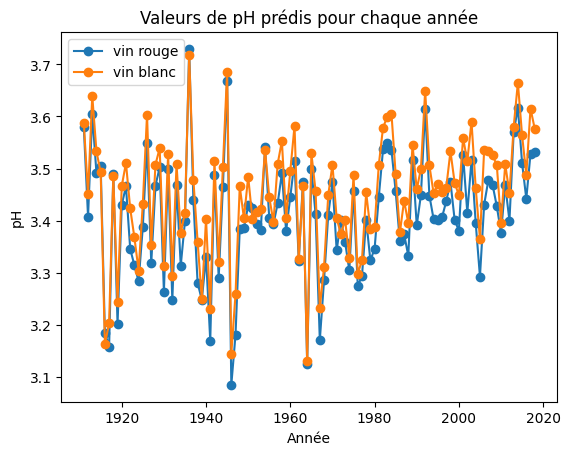

In [389]:
plt.plot(date, y_predicted_red, '-o', label='vin rouge')
plt.plot(date, y_predicted_white, '-o', label='vin blanc')
plt.legend()
plt.xlabel('Année')
plt.ylabel('pH')
plt.title('Valeurs de pH prédis pour chaque année')
plt.show()


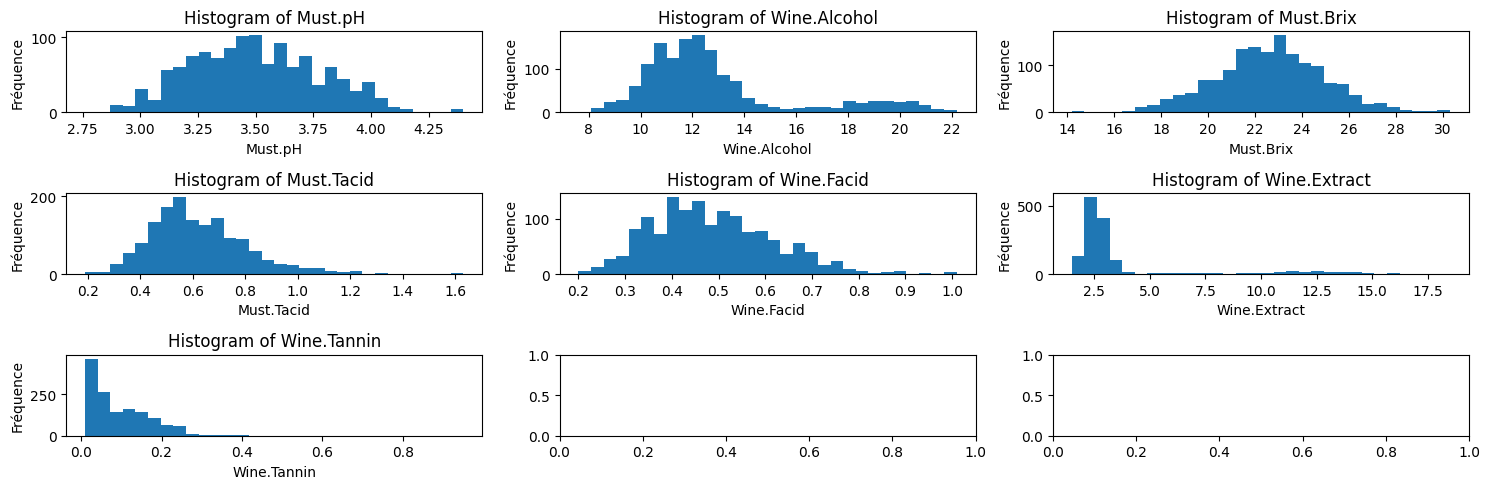

In [ ]:
#Histogramme représentant la fréquence de notre y en fonction de y
colonnes_a_predire = ['Must.pH','Wine.Alcohol','Must.Brix', 'Must.Tacid', 'Wine.Facid', 'Wine.Extract', 'Wine.Tannin']
fig, axes = plt.subplots(nrows=math.ceil(len(colonnes_a_predire)/3), ncols=3, figsize=(15, 5))
for i, colonne in enumerate(colonnes_a_predire):
    ax = axes[i//3, i%3]
    ax.hist(wines[colonne], bins=30)
    ax.set_xlabel(colonne)
    ax.set_ylabel('Fréquence')
    ax.set_title(f'Histogram of {colonne}')

plt.tight_layout()
plt.show()

